In [1]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline

import scipy

from scipy.optimize import fsolve

from itertools import combinations

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

import os
import sys

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools



# sns.set_style('dark')
# sns.set_style('ticks')
# plt.style.use('dark_background')

We want to infer the DFE for each starting genotype from each evolution condition. 

For practice, let's start with the data from Levy 2015

In [2]:
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [3]:
condition_properties = {
                        'Levy2015':{1:[0,16,32,40,48,64,72,80,88,96,104,112],
                                   2:[0,8,24,40,48,56,64,72,88,96] },
#                         'Evo1D_IRAs':{1:[0,1,4,7,10,13,16,19,22,24],
#                                       2:[0,1,4,7,10,13,16,19,22,24]},
#                         'Evo1D_TCG':{1:[0,1,4,8,10,13,16,19,22,24],
#                                     2:[0,1,4,8,10,13,16,19,22,24]},
                        
                        'Evo2D_Ira1_Mis':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
                        'Evo2D_Ira1_Non':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
                        
                        'Evo2D_CYR1':{1:[0, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
                                         2:[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 128, 136, 144, 152, 160]},
                        'Evo2D_GPB2':{1:[0, 8, 32, 56, 64, 80, 104, 120],
                                         2:[0, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 136, 144, 160]},
                        'Evo2D_TOR1':{1:[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
                                         2:[0, 16, 24, 40, 48, 64, 72, 88, 104, 112, 120, 128, 136, 152, 160]},                        
                        
                        'Evo3D_Ira1_Mis':{1:[0,1,4,7,10,14,17,21],
                                         2:[0,1,4,7,10,14,17,21],
                                         3:[0,1,4,7,10,14,17,21]},
                        'Evo3D_Ira1_Non':{1:[0,1,4,7,10,14,17,21],
                                         2:[0,1,4,7,10,14,17,21],
                                         3:[0,1,4,7,10,14,17,21]},
                        
#                         'Evo3D_TCG':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21]},               
                       }

# condition_properties = {}

aggeli_conditions = {'Evo2D_CYR1':'Cyr1Evo',
                     'Evo2D_GPB2':'Gpb2Evo',
                     'Evo2D_TOR1':'Tor1Evo'
                    }


n_gens = 8
effective_n = 6 * 10**8 
# effective_lineage_size = 

cov_thresh = 1e5

# program_used = 'fitmut2'
program_used = 'fitmut1'

if program_used == 'fitmut1':
    
    figure_directory = 'figures/fitmut1/'
    result_directory = 'FitMut2_processing/out_fitmut1_thresholded/'
    
elif program_used == 'fitmut2':
    figure_directory = 'figures/fitmut2/'
    result_directory = 'FitMut2_processing/out_thresholded/'

plot_trajs = False


In [4]:
shared_adaptives = {}
max_fitness_dict = {}
establishment_time_dict = {}

for condition,reps in condition_properties.items():
    
    adaptive_ixs = []
    max_fitness_dict[condition] = 0
    establishment_time_dict[condition] = [0,0]
    
    for rep,timepoints in reps.items():
        
        this_fit_mut = p.read_csv(f'{result_directory}{condition}_{rep}_MutSeq_Result.csv')
        
        adaptive_ix_here = (this_fit_mut['Fitness']>0)
        max_fitness_dict[condition] = np.max([max_fitness_dict[condition],np.max(this_fit_mut['Fitness'])])
        establishment_time_dict[condition][0] = np.min([establishment_time_dict[condition][0],np.min(this_fit_mut['Establishment_Time'])])
        establishment_time_dict[condition][1] = np.max([establishment_time_dict[condition][1],np.max(this_fit_mut['Establishment_Time'])])
        
        adaptive_ixs.append(adaptive_ix_here)
#         print(len(adaptive_ix_here))
    if len(adaptive_ixs[0]) == len(adaptive_ixs[1]): 
        shared_adaptives[f'{condition}'] = np.all(adaptive_ixs,axis=0)
    else:
        shared_adaptives[f'{condition}'] = []
        
        

In [5]:
condition_colors = {key:sns.color_palette()[i] for i,key in enumerate(condition_properties.keys())}


# condition_properties = {'Evo3D_Ira1_Non':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21],
#                                          3:[0,1,4,7,10,14,17,21]}}


fitmuts_big = {}
mean_fitness_big = {}
kappas_big = {}
mutant_cell_fraction_big = {}
used_timepoints_big = {}
freqs_big = {}


for condition,reps in condition_properties.items():
    
    
    if plot_trajs:
        traj_fig,traj_ax = plt.subplots(figsize=(12,4*len(reps)),nrows=len(reps),ncols=2)
    
    if ('Levy2015' not in condition) and (condition not in aggeli_conditions.keys()):
        this_data = p.read_csv(f'{condition}_counts_curated.csv')

    for rep,timepoints in reps.items():
#         this_data = p.read_csv(f'{condition}_{rep}_counts_original.csv')
        
        used_timepoints = []
        all_samples = []
         
        if 'Levy2015' in condition:
            this_data = p.read_csv(f'{condition}_{rep}_counts_original.csv')
            
            for time in timepoints:
                sample_name = f't={time}'

                if np.sum(this_data[sample_name]) > cov_thresh:

                    all_samples.append(sample_name)
                    used_timepoints.append(time)
        
        elif condition in aggeli_conditions.keys():
            this_data = p.read_csv(f'{home_dir}/EvolutionTracking/Aggeli2021_data/{aggeli_conditions[condition]}{rep}_CountsTimecourse.txt',sep='\t')

            for time in timepoints:
                if np.sum(this_data[str(time)]) > cov_thresh:
                    used_timepoints.append(time)
                    all_samples.append(str(time))
            
        else:
            for time in timepoints:
                if time == 0:
                    sample_name = f'{condition}_0_0_count'
    #                 all_samples.append()
                else:
                    sample_name = f'{condition}_{rep}_{time}_count'

                if np.sum(this_data[sample_name]) > cov_thresh:

                    all_samples.append(sample_name)
                    used_timepoints.append(time)
                
        used_timepoints_big[f'{condition}_{rep}'] = used_timepoints

#         this_fit_mut = p.read_csv(f'FitMut2_processing/out_fitmut1_thresholded/{condition}_{rep}_MutSeq_Result.csv')
        this_fit_mut = p.read_csv(f'{result_directory}{condition}_{rep}_MutSeq_Result.csv')
        fitmuts_big[f'{condition}_{rep}'] = this_fit_mut

        mean_fitness = this_fit_mut['Mean_Fitness'].values
        mean_fitness = mean_fitness[~np.isnan(mean_fitness)]
        mean_fitness_big[f'{condition}_{rep}'] = mean_fitness

        kappas = this_fit_mut['Kappa_Value'].values
        kappas = kappas[~np.isnan(kappas)]
        kappas_big[f'{condition}_{rep}'] = kappas


        mutant_cell_fraction = this_fit_mut['Mutant_Cell_Fraction'].values
        mutant_cell_fraction = mutant_cell_fraction[~np.isnan(mutant_cell_fraction)]
        mutant_cell_fraction_big[f'{condition}_{rep}'] = mutant_cell_fraction

        this_fit_mut = this_fit_mut[['Fitness','Establishment_Time','Error_Fitness','Error_Establishment_Time']]
#         this_fit_mut['barcode'] = this_mut

        
        
        fitness_order = np.argsort(this_fit_mut['Fitness'].values)
        
        these_ts = np.tile(used_timepoints,this_data[all_samples].shape[0]).reshape(this_data[all_samples].shape)
        these_freqs = (this_data[all_samples]/np.nansum(this_data[all_samples],axis=0)).values
        
        freqs_big[f'{condition}_{rep}'] = these_freqs
        
        
        
        these_freqs = these_freqs[fitness_order,:]
        
#         traj_fit.add_subplot()
        if plot_trajs:
            lc = multiline(these_ts,these_freqs, 
                           this_fit_mut['Fitness'].values[fitness_order], ax=traj_ax[rep-1,0],
                           cmap='Reds', lw=0.5,norm=plt.Normalize(vmin=0,vmax=max_fitness_dict[condition]))

            axcb = traj_fig.colorbar(lc,ax=traj_ax[rep-1,0])
            axcb.set_label('Fitness')

            traj_ax[rep-1,0].set_yscale('log')
            traj_ax[rep-1,0].set_xticks(used_timepoints,used_timepoints)

            traj_ax[rep-1,0].set_xlabel('Transfer')
            traj_ax[rep-1,0].set_ylabel('Frequency')

    #         traj_fit.add_subplot()

            traj_ax[rep-1,0].set_facecolor('lightgrey')

            lc = multiline(these_ts,these_freqs, 
                           this_fit_mut['Establishment_Time'].values[fitness_order], ax=traj_ax[rep-1,1],
                           cmap='Blues', lw=0.5,norm=plt.Normalize(vmin=establishment_time_dict[condition][0],vmax=establishment_time_dict[condition][1]))

            axcb = traj_fig.colorbar(lc,ax=traj_ax[rep-1,1])
            axcb.set_label('Establishment Time')

            traj_ax[rep-1,1].set_yscale('log')
            traj_ax[rep-1,1].set_xticks(used_timepoints,used_timepoints)

            traj_ax[rep-1,1].set_xlabel('Transfer')
            traj_ax[rep-1,1].set_ylabel('Frequency')

            traj_ax[rep-1,1].set_facecolor('lightgrey')
        
    if plot_trajs:
        traj_fig.tight_layout()
        traj_fig.savefig(f'{figure_directory}{condition}_trajectories_fitness_establishment.pdf',bbox_inches='tight')
    #     traj_fig.savefig(f'figures/fitmut1/{condition}_trajectories_fitness_establishment.pdf',bbox_inches='tight')




/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/942498991.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


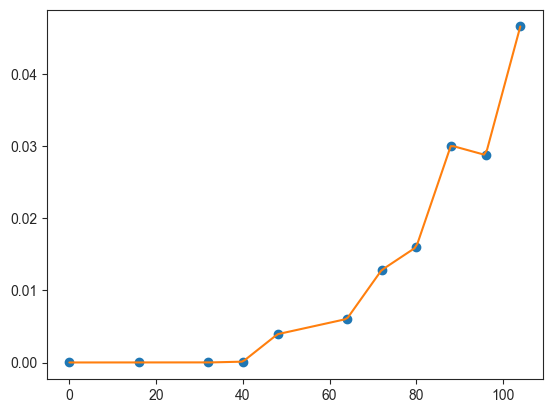

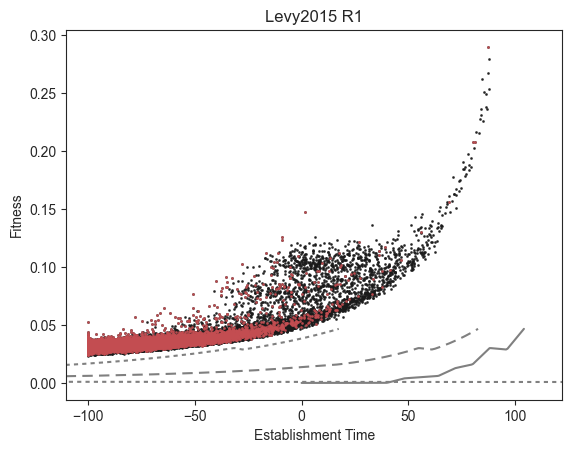

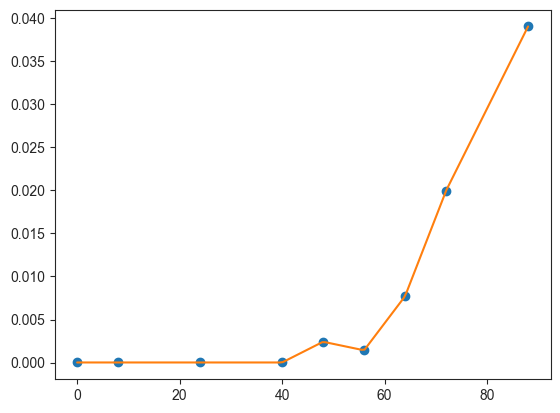

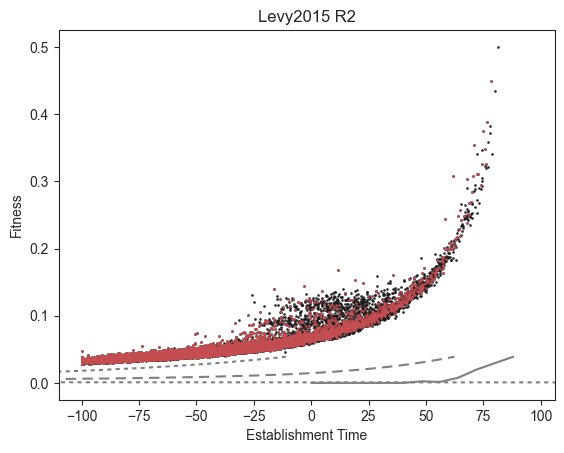

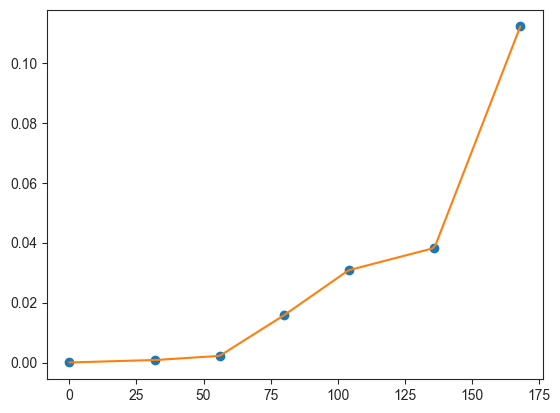

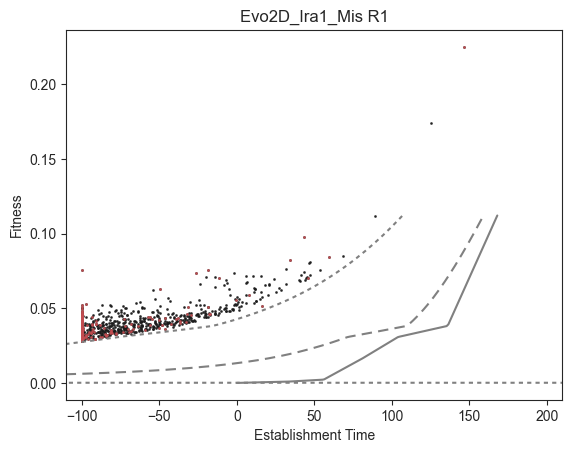

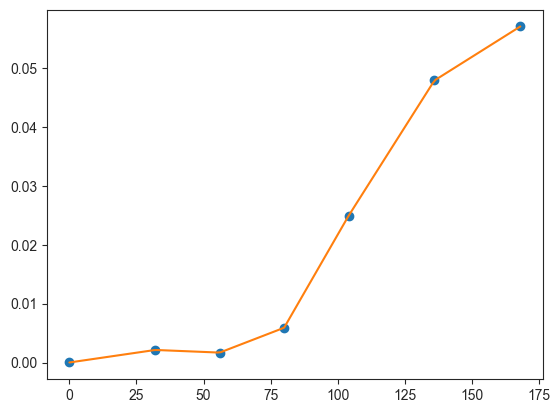

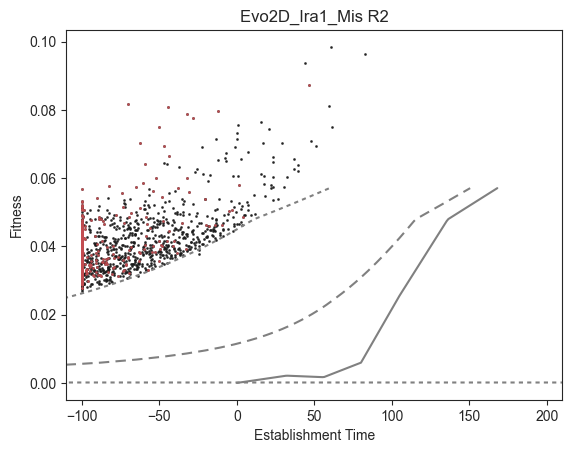

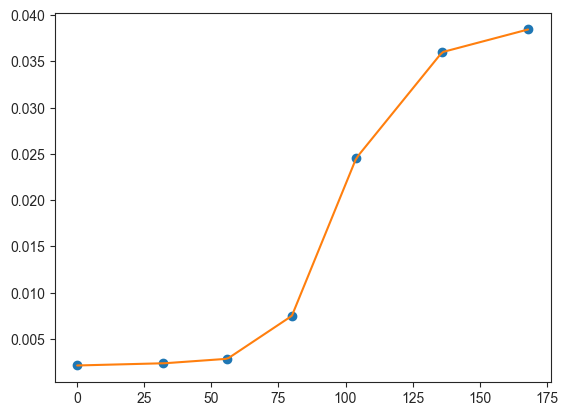

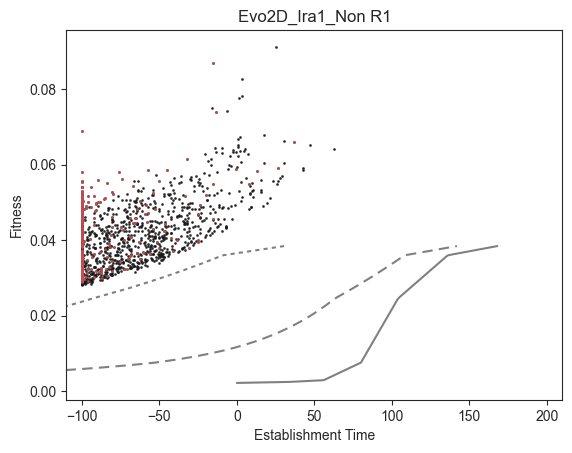

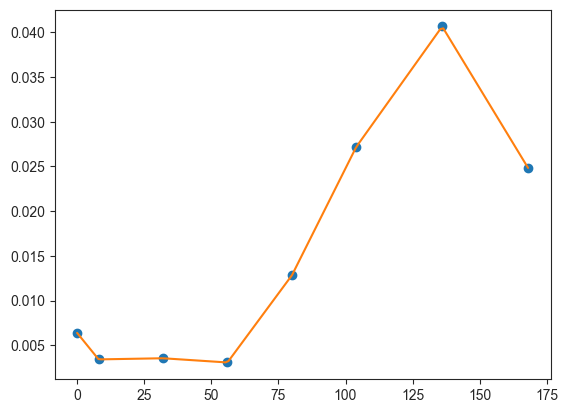

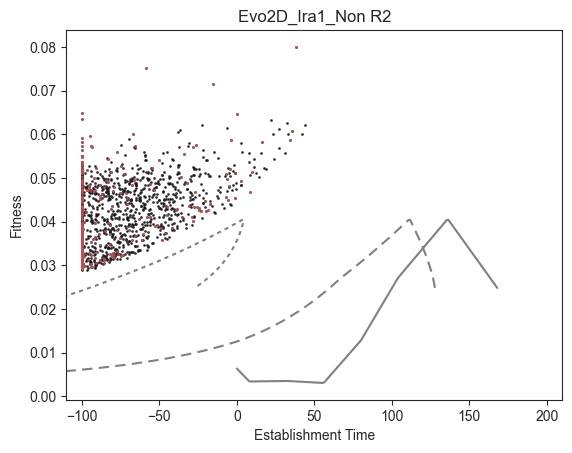

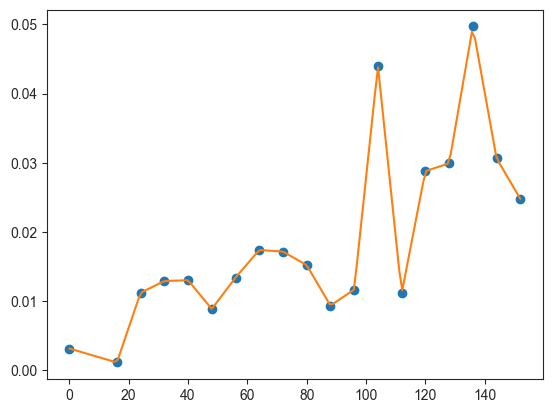

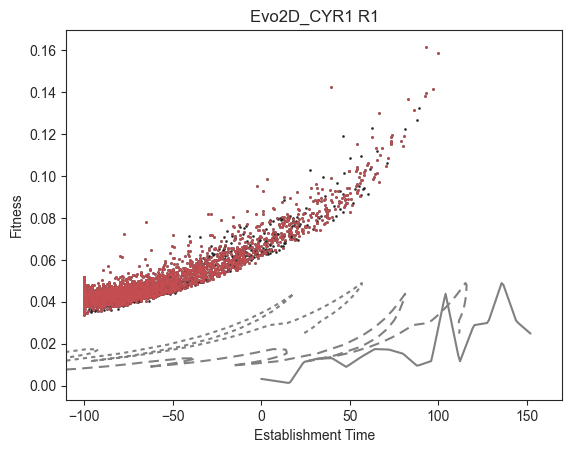

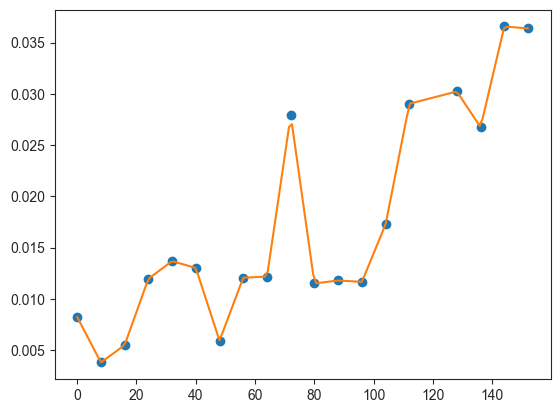

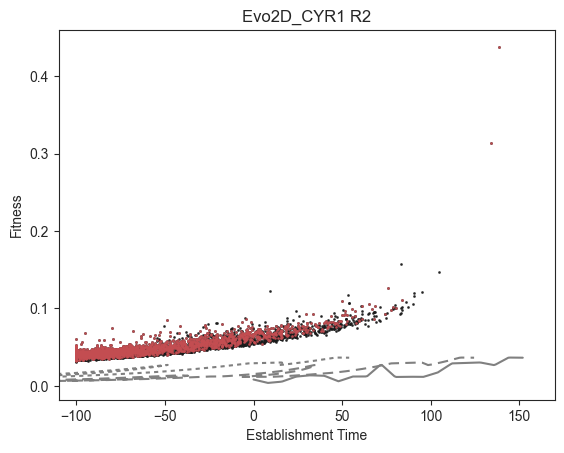

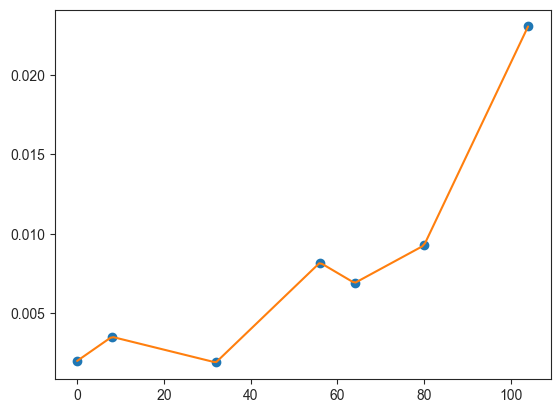

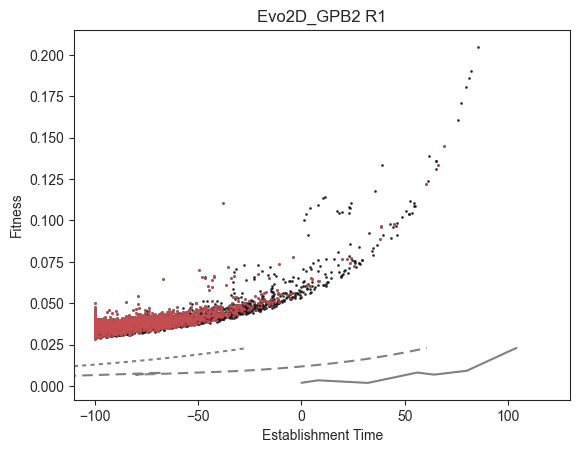

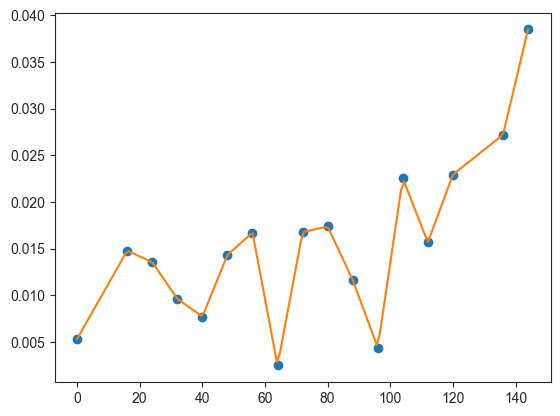

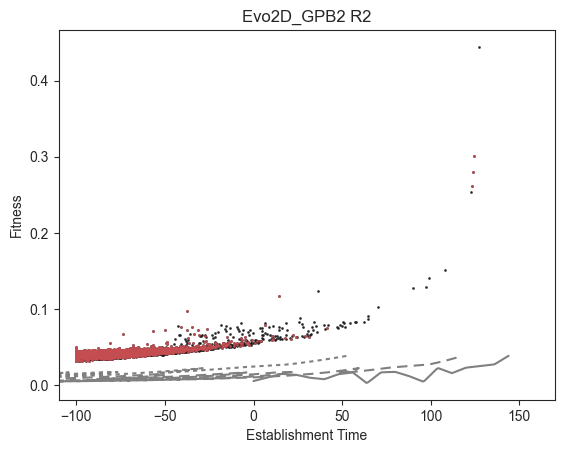

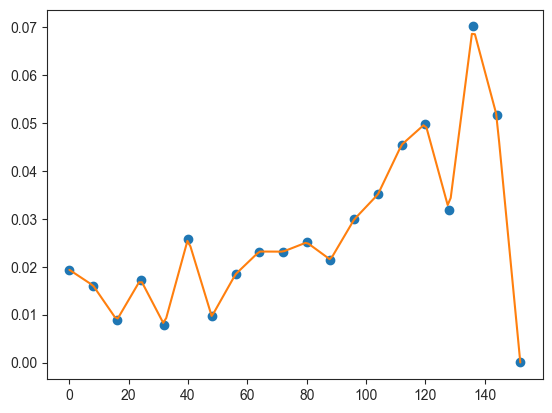

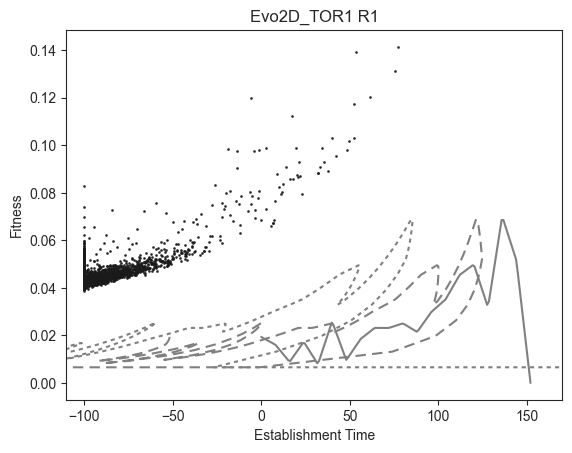

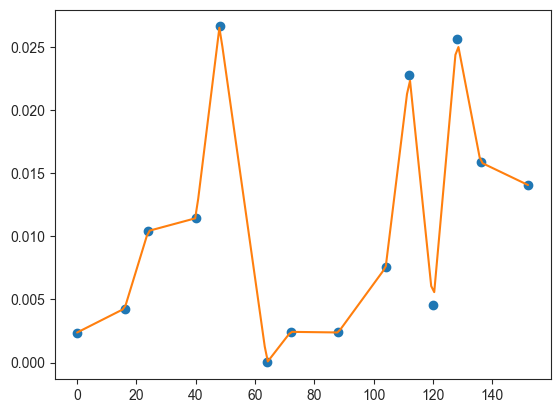

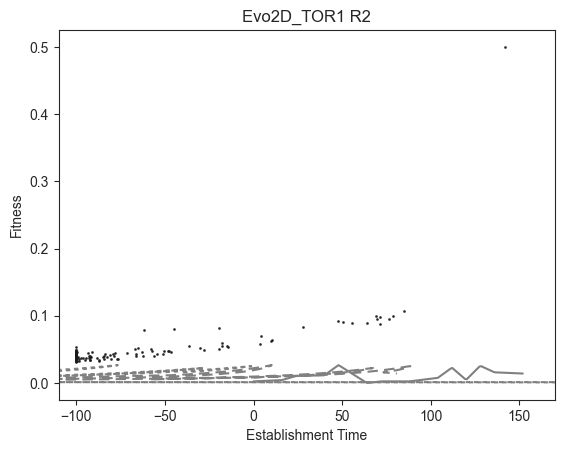

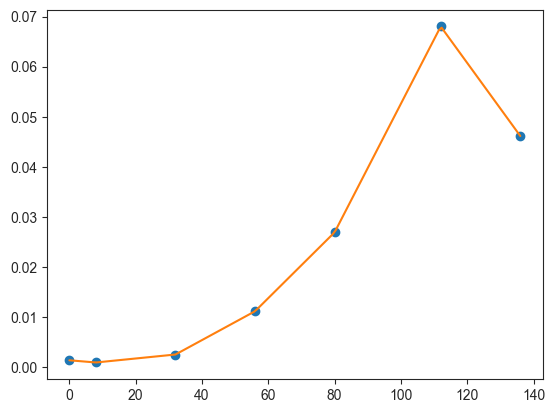

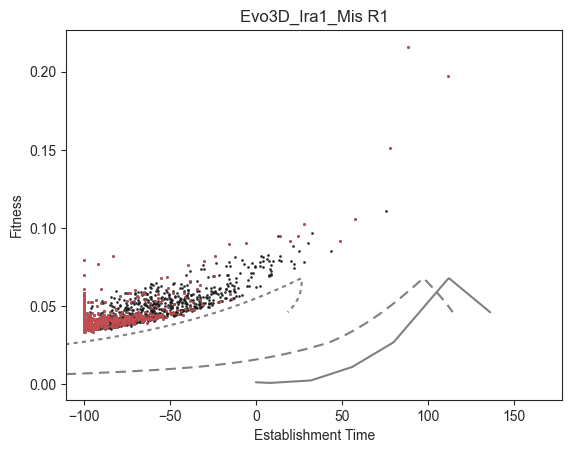

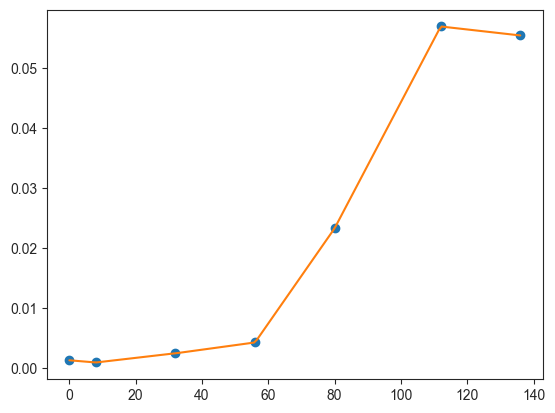

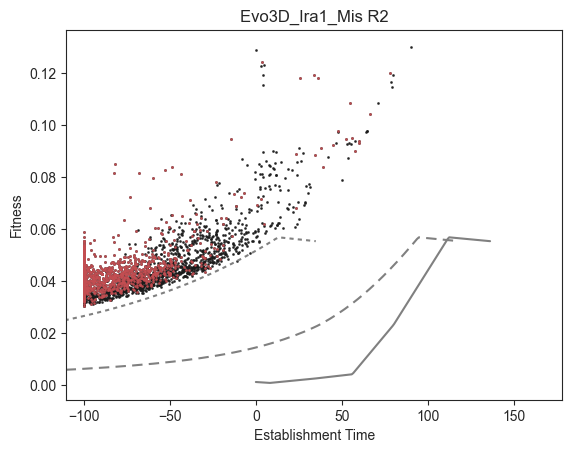

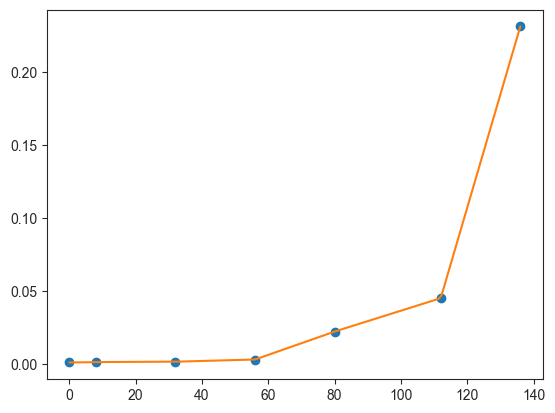

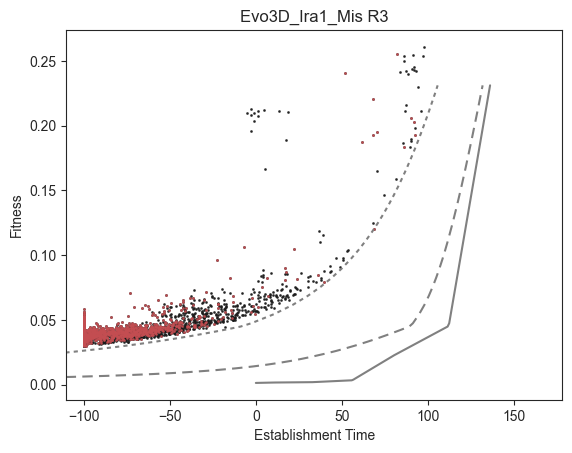

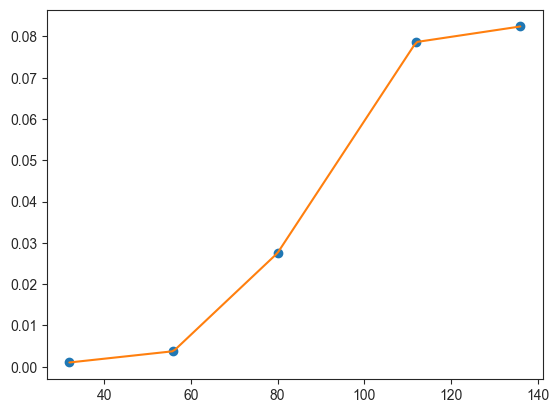

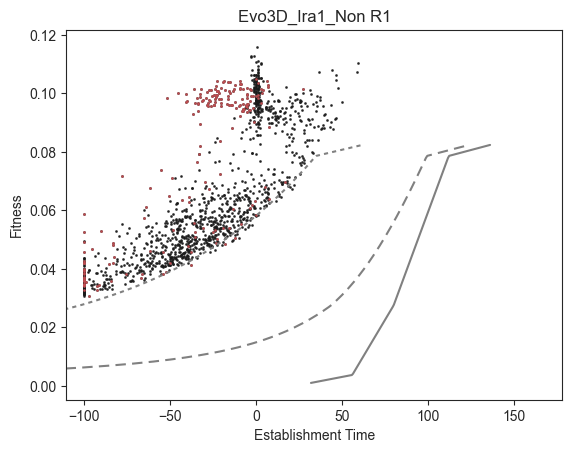

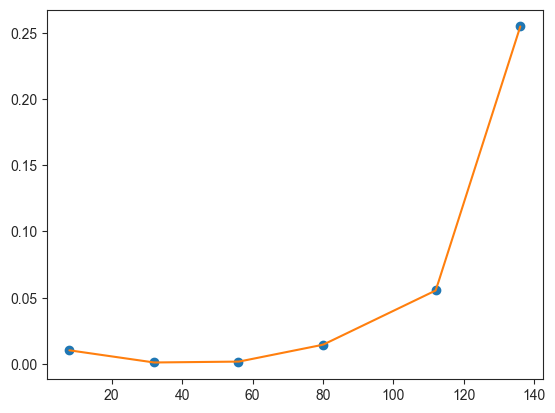

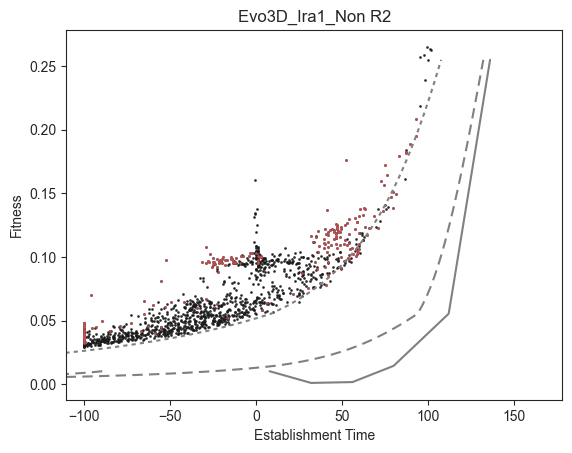

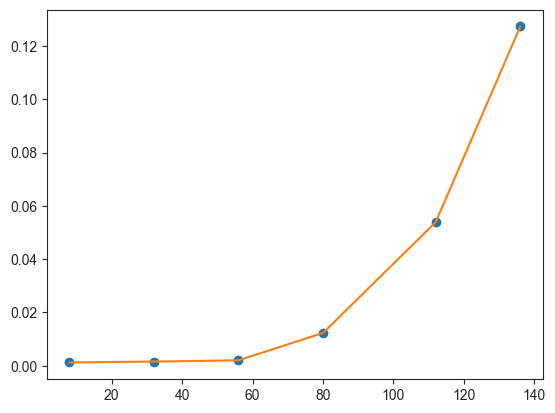

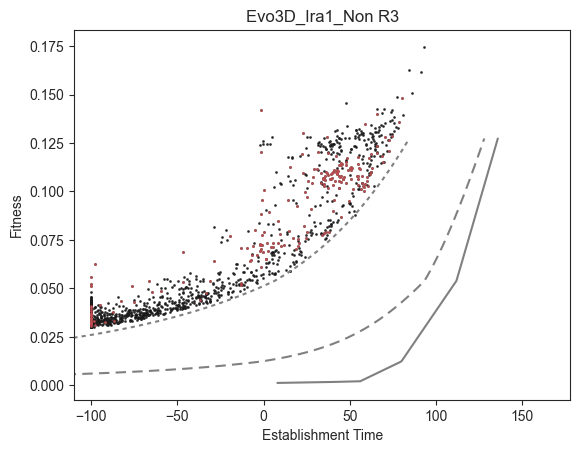

In [6]:
# adaptive_ix = np.where(this_fit_mut['Fitness'] > 0 )[0]

for condition,reps in condition_properties.items():
    
#     shared_list = []
    
    for rep,timepoints in reps.items():

        this_fit_mut = fitmuts_big[f'{condition}_{rep}']
        mean_fitness = mean_fitness_big[f'{condition}_{rep}']
        used_timepoints = used_timepoints_big[f'{condition}_{rep}']
        
        if 'Levy2015' in condition:
            used_timepoints = np.asarray(used_timepoints)
        elif condition in aggeli_conditions:
            used_timepoints = np.asarray(used_timepoints)
        else:
            used_timepoints = 8*np.asarray(used_timepoints)
        
        effective_lineage_size = effective_n/len(this_fit_mut)
        
         
        adaptives = this_fit_mut[this_fit_mut['Fitness'] > 0]
        
        adaptive_ix = np.where(this_fit_mut['Fitness'] > 0)
        shared_ix = np.where(shared_adaptives[condition]==True)
        
        if program_used == 'fitmut1':
            interpolationf = scipy.interpolate.interp1d(used_timepoints[:-1],mean_fitness,kind=1)
            ts = np.linspace(used_timepoints[0],used_timepoints[-2],150)
        else:
            interpolationf = scipy.interpolate.interp1d(used_timepoints,mean_fitness,kind=1)
            ts = np.linspace(used_timepoints[0],used_timepoints[-1],150)

        mean_fitness_est = interpolationf(ts)

        s_vals = mean_fitness_est
        ts_clonal = [ts[i]-(1/sval) for i,sval in enumerate(s_vals)]
        ts_clonal_size = [ts[i]-(1/sval)*np.log(effective_lineage_size*sval) for i,sval in enumerate(s_vals)]
        
        plt.figure()
        if program_used == 'fitmut1':
            plt.plot(used_timepoints[:-1],mean_fitness,'o')
            plt.plot(ts,mean_fitness_est)
        else:
            plt.plot(used_timepoints,mean_fitness,'o')
            plt.plot(ts,mean_fitness_est)
        
        plt.figure()
        plt.title(f'{condition} R{rep}')
        

        # last_t_count = this_data[]

#         plt.scatter(adaptives['Establishment_Time'],adaptives['Fitness'],alpha=0.8,s=1)
        plt.scatter(this_fit_mut['Establishment_Time'].values[adaptive_ix],this_fit_mut['Fitness'].values[adaptive_ix],alpha=0.8,s=1,color='k')
        plt.scatter(this_fit_mut['Establishment_Time'].values[shared_ix],this_fit_mut['Fitness'].values[shared_ix],alpha=0.8,s=1,color='r')
        # used_timepoints = [8,32,56,80,112,136,168]

        # ts = 

        # plt.plot(8*np.asarray(timepoints[2:]),mean_fitness,color='k')
        # plt.plot(used_timepoints[:-1],mean_fitness,color='k')
        # plt.plot(ts_clonal,mean_fitness,color='k',linestyle='--')
        # plt.plot(ts_clonal_size,mean_fitness,color='k',linestyle=':')

        plt.plot(ts,mean_fitness_est,color='gray')
        plt.plot(ts_clonal,mean_fitness_est,color='gray',linestyle='--',dashes=(5, 3))
        plt.plot(ts_clonal_size,mean_fitness_est,color='gray',linestyle='--',dashes=(2, 2))

        plt.xlim(np.min(adaptives['Establishment_Time'])-10,used_timepoints[-1]+10)

        plt.xlabel('Establishment Time')
        plt.ylabel('Fitness')

# plt.savefig(f'figures/fitmut1/{condition}_{rep}_Establishment_vs_Fitness_lined.pdf',bbox_inches='tight')

Text(0, 0.5, 'Mean Fitness')

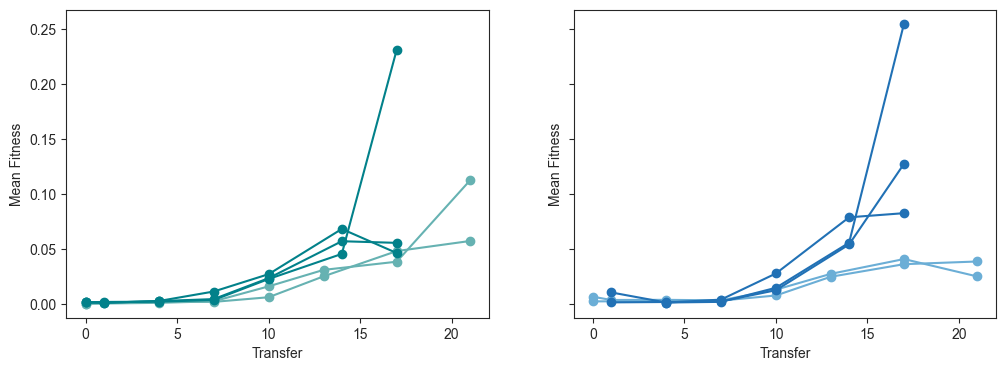

In [7]:
fig,axs = plt.subplots(figsize=(6*2,4),ncols=2,sharey=True)

for condition,reps in condition_properties.items():
    
#     shared_list = []
    
    for rep,timepoints in reps.items():

        this_fit_mut = fitmuts_big[f'{condition}_{rep}']
        mean_fitness = mean_fitness_big[f'{condition}_{rep}']
        used_timepoints = used_timepoints_big[f'{condition}_{rep}']
        
        if 'Ira1_Mis' in condition:
            
            evo_cond,ancestor = condition.split('_',1)
            
            axs[0].plot(used_timepoints[:-1],mean_fitness,'o',linestyle='-',label=f'{condition}_{rep}',
                     color=tools.anc_evo_cond_color_map[ancestor.upper()][evo_cond])
        elif 'Ira1_Non' in condition:
            evo_cond,ancestor = condition.split('_',1)
            
            axs[1].plot(used_timepoints[:-1],mean_fitness,'o',linestyle='-',label=f'{condition}_{rep}',
                     color=tools.anc_evo_cond_color_map[ancestor.upper()][evo_cond])
            
            
# axs[1].set_yscale('log')
# axs[0].set_yscale('log')
axs[0].set_xlabel('Transfer')
axs[0].set_ylabel('Mean Fitness')
axs[1].set_xlabel('Transfer')
axs[1].set_ylabel('Mean Fitness')

In [8]:

# Eq.  (Line 292 of mathematica)
# def establishment_size(s,t,interpolated_mean_fitness,delta_s):
    
#     return (1/(s-interpolated_mean_fitness(t)) * np.heaviside(s-(interpolated_mean_fitness(t)+delta_s)) 
#             + (1/delta_s)* np.heaviside(-(s-(interpolated_mean_fitness(t)+delta_s))) 
    

## Deterministic calculation

One way of calculating the distrubtion of fitness effects is by using a deterministic approximation (taken from 11.1 of Levy/Blundell supplement). 
This assumes that there is a very large popluation of neutral cells that is feeding the population at a rate of $\mu(s)ds$ 

$ f(ds,t) = \frac{\mu(s)ds}{s} e^{st}$ 

However, we must account for the fact that some of the mutations were pre-existing, which provides an existing source (and time) for these mutations to arise. This additional fraction is given by:

$ (\text{additional pre-existing fraction}) = \mu(s)\delta s \ln\left(N_f \mu(s)\delta s\right) e^{st} $

where $ N_f ~ 10^{12} $ is the maximum population size the population reached after barcoding, before the separation of replicates. Accounting for this additional fraction, the inferred mutation rate density is thus:

$ \mu(s) ds = \frac{f(ds,t)}{1+s\ln\left(N_f \mu(s) \delta s \right)} $ 

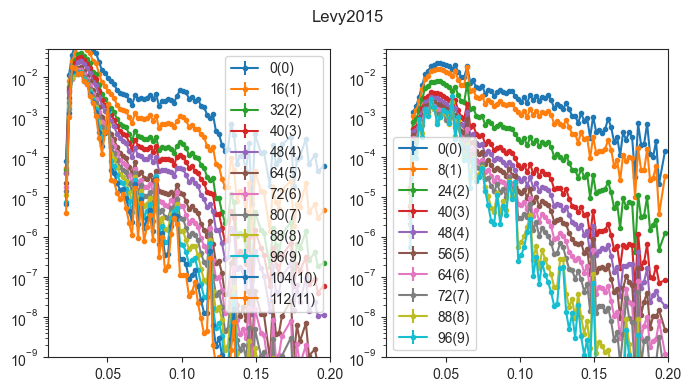

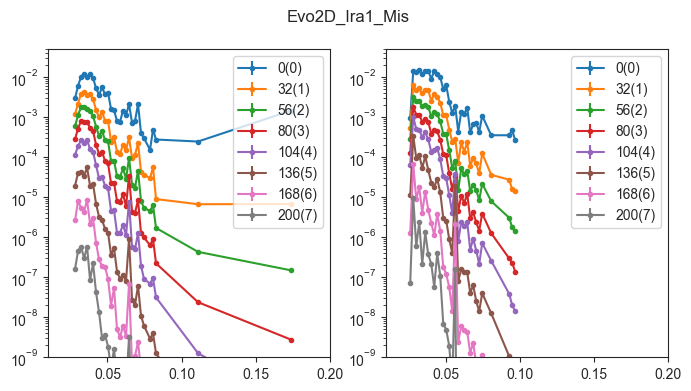

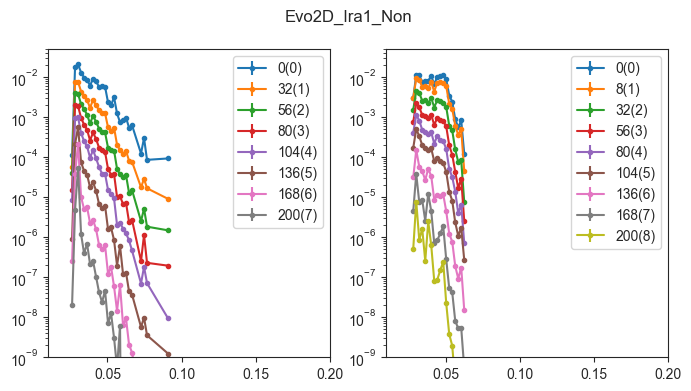

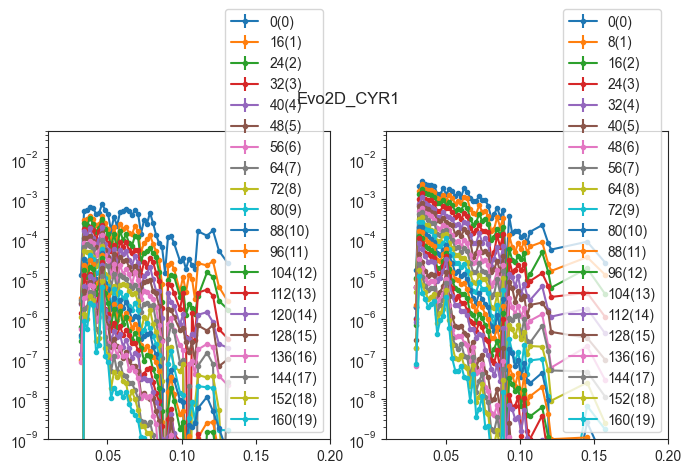

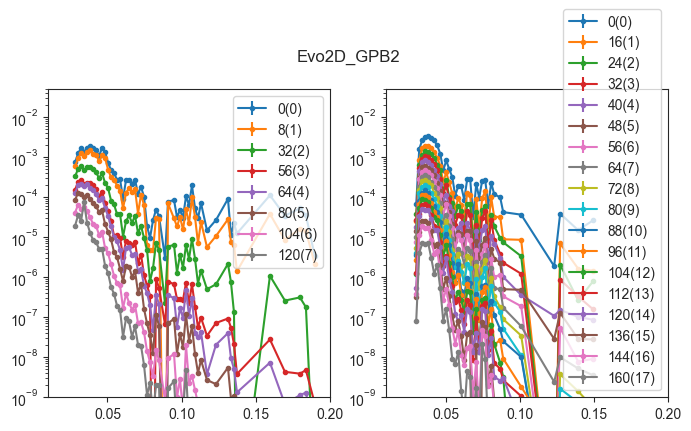

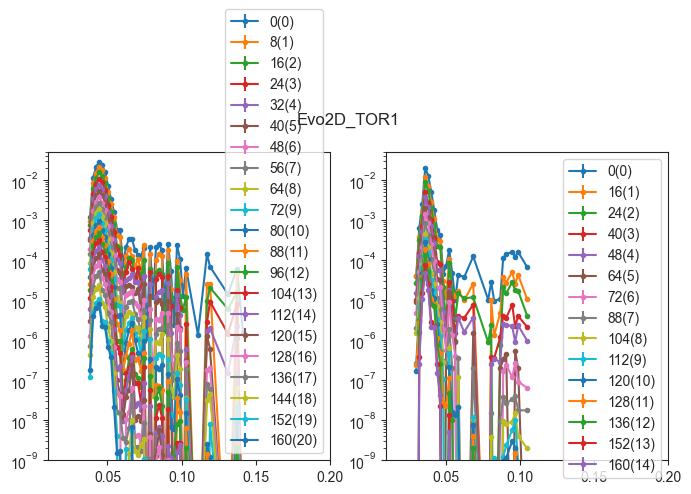

In [22]:
# delta_s = 0.002
delta_s = 0.002

s_min = 0.01
s_max = 0.2

s_space = np.linspace(s_min,s_max,int((s_max-s_min)/delta_s))

N_f = 10**12

# chosen_transfer = 5

# chosen_timepoint = 32

def mu_func(mu,s,delta_s,f,t,N_f=10**12):
    
    return mu*delta_s * (1 + s *np.log(N_f*mu*delta_s)) - f * s/(np.exp(s*t))


def mu_error(mu,delta_s,Ne=6*10**8):
    
    return np.sqrt(mu*delta_s/Ne)

deterministic_dfe_ests = {}

for condition,reps in condition_properties.items():
    plt.figure(figsize=(4*len(reps),4))
    plt.suptitle(condition)
    
    for rep,timepoints in reps.items():
        
        deterministic_dfe_ests[f'{condition}_{rep}'] = {}
        
        this_fit_mut = fitmuts_big[f'{condition}_{rep}']
        mean_fitness = mean_fitness_big[f'{condition}_{rep}']
        used_timepoints = used_timepoints_big[f'{condition}_{rep}']
        these_freqs = freqs_big[f'{condition}_{rep}']
        
        if 'Levy2015' in condition:
            used_timepoints = np.asarray(used_timepoints)
        elif condition in aggeli_conditions:
            used_timepoints = np.asarray(used_timepoints)
        else:
            used_timepoints = 8*np.asarray(used_timepoints)
        
        if len(shared_adaptives[condition]) > 0:
            unshared = this_fit_mut[~shared_adaptives[condition]]
         
            adaptives = unshared[unshared['Fitness'] > 0]
        else:
            adaptives = this_fit_mut[this_fit_mut['Fitness'] > 0 ]
#         adaptives = adaptives[adaptives['Establishment_Time']>-20]
#         adaptives = adaptives[~shared_adaptives[]
        
    
        plt.subplot(1,len(reps),rep)

        for chosen_transfer in range(len(used_timepoints)):
            mus = []
            mu_errors = []
            for s in s_space:

                adaptives_here = adaptives[adaptives['Fitness'].between(s,s+delta_s)]

                interval_lineages = np.where(adaptives['Fitness'].between(s,s+delta_s))[0]

                freqs_here = these_freqs[interval_lineages,chosen_transfer]

                if len(adaptives_here) > 0:

                    out = fsolve(mu_func,(1),args=(s,delta_s,np.sum(freqs_here),used_timepoints[chosen_transfer],N_f))
                    err = mu_error(out,delta_s)
                    mus.append(out[0])
                    mu_errors.append(err[0])
                else:

                    mus.append(np.nan)
                    mu_errors.append(np.nan)
                    
            mus = np.asarray(mus)
            mu_errors = np.asarray(mu_errors)
            
            deterministic_dfe_ests[f'{condition}_{rep}'][used_timepoints[chosen_transfer]] = mus
    
            mus_mask = np.isfinite(mus)
            plt.errorbar(s_space[mus_mask],mus[mus_mask],
                         yerr=mu_errors[mus_mask],
                         marker='.',
                         linestyle='-',
                         label=f'{used_timepoints[chosen_transfer]}({chosen_transfer})')
        plt.legend()
        plt.yscale('log')
        
        plt.ylim(10**-9,5*10**-2)
        plt.xlim(s_min,s_max)
        
    plt.savefig(f'{figure_directory}/mutation_rate_spectrum_deterministic_by_time_{condition}.pdf',bbox_inches='tight')
        

[1.22962699e-05 1.11609853e-05 1.14442346e-05 1.24727751e-04
 3.93222954e-03 6.05017806e-03 1.28177298e-02 1.60080798e-02
 3.00985931e-02 2.87745494e-02 4.66040502e-02]
[0.88637369 0.87269479 0.85032626 0.83449136 0.8153752  0.73892031
 0.69131279 0.63378095 0.56538052 0.4672351  0.38954257 0.28322209]
0.8863736891037346


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  time_to_occur = scipy.integrate.quad(time_occurence_function,
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  time_to_occur = scipy.integrate.quad(time_occurence_function,


[1.20728613e-05 1.06693335e-05 1.12816029e-05 1.07399859e-05
 2.41742603e-03 1.42440233e-03 7.71043469e-03 1.99617470e-02
 3.90372063e-02]
[0.93359942 0.92938036 0.92058443 0.90344958 0.88960005 0.86220143
 0.83577521 0.7937916  0.63863615 0.51278311]
0.9335994229383623
[1.01933466e-05 8.21724628e-04 2.22016388e-03 1.57970592e-02
 3.07831426e-02 3.82359466e-02 1.12138494e-01]
[0.97603139 0.96467406 0.94881376 0.87756018 0.58506656 0.22705079
 0.07265905 0.00948276]
0.9760313944582849


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  time_to_occur = scipy.integrate.quad(time_occurence_function,
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  time_to_occur = scipy.integrate.quad(time_occurence_function,


[1.00351096e-05 2.13702026e-03 1.68951959e-03 5.90929784e-03
 2.49103524e-02 4.79081300e-02 5.70817569e-02]
[0.96972432 0.95753847 0.9438137  0.90180988 0.77986872 0.35156993
 0.08022041 0.01167132]
0.9697243186820284
[0.00213604 0.00236425 0.00285921 0.00749736 0.02454427 0.03598595
 0.03843644]
[0.97666363 0.97091874 0.96057804 0.92473973 0.81927012 0.42262123
 0.14841465 0.04057408]
0.9766636316212424


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  time_to_occur = scipy.integrate.quad(time_occurence_function,
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  time_to_occur = scipy.integrate.quad(time_occurence_function,


[0.00637669 0.00341578 0.00354267 0.00307094 0.01280936 0.02718363
 0.04065186 0.02483598]
[0.97809637 0.97571163 0.97341171 0.96331635 0.93241388 0.79839681
 0.365539   0.11092351 0.03910654]
0.9780963675582329
[0.00317379 0.0011584  0.01122926 0.01292776 0.01304455 0.00888686
 0.0134267  0.01740871 0.01718336 0.01522077 0.00937834 0.01169962
 0.04403006 0.01113717 0.02880876 0.02993726 0.04971035 0.03065613
 0.02480162]
[0.98913731 0.9848192  0.97502206 0.96888414 0.96050971 0.9533856
 0.94178111 0.94036715 0.91896113 0.89845006 0.89209062 0.86465644
 0.85680626 0.77305174 0.75997056 0.67201385 0.72734339 0.54220863
 0.4684757  0.40433123]
0.9891373085839454


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  time_to_occur = scipy.integrate.quad(time_occurence_function,
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  time_to_occur = scipy.integrate.quad(time_occurence_function,


[0.00824359 0.00379821 0.00549132 0.01195701 0.01368796 0.01302081
 0.00592118 0.01207524 0.01217137 0.02792457 0.01150517 0.01179734
 0.01166437 0.0172983  0.02904374 0.03023704 0.02674941 0.03657976
 0.03638901]
[0.98669878 0.98319223 0.98053896 0.97499576 0.97217978 0.96973535
 0.95651156 0.94502101 0.92049819 0.91562029 0.89395155 0.86507963
 0.8271817  0.78339077 0.73320811 0.59977689 0.52981595 0.44676883
 0.37316269 0.30404832]
0.9866987770455503
[0.00199071 0.00351047 0.00189324 0.00818195 0.00689539 0.00926378
 0.02305001]
[0.98780764 0.98326947 0.97578941 0.95684835 0.93722823 0.9097277
 0.78389611 0.56975683]
0.9878076418869528


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  time_to_occur = scipy.integrate.quad(time_occurence_function,


[0.00533632 0.01479842 0.01355191 0.00963578 0.00772732 0.01434408
 0.01673424 0.00249096 0.01678333 0.01738201 0.0116586  0.00439591
 0.02255386 0.01567237 0.02294336 0.02720906 0.03849045]
[0.98510347 0.9663875  0.96283336 0.95583604 0.97998987 0.9779879
 0.97244006 0.94343444 0.92756985 0.91740559 0.89844551 0.87443662
 0.83497649 0.79606674 0.73627814 0.62082485 0.53151701 0.32526639]
0.9851034650992332


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  time_to_occur = scipy.integrate.quad(time_occurence_function,


[1.93488141e-02 1.60711534e-02 8.86640736e-03 1.73114461e-02
 7.83495422e-03 2.58665778e-02 9.62013910e-03 1.84182099e-02
 2.31671944e-02 2.31437309e-02 2.50752258e-02 2.14535867e-02
 2.98676370e-02 3.50949181e-02 4.54553749e-02 4.98761200e-02
 3.17799809e-02 7.01408475e-02 5.16311986e-02 1.00000000e-05]
[0.97634827 0.96767291 0.96177451 0.95381939 0.93541089 0.92360085
 0.88639152 0.85541758 0.79784428 0.7325858  0.68969351 0.63882862
 0.56505329 0.48383843 0.40876193 0.33776031 0.24555706 0.18090269
 0.11299991 0.06847648 0.06499821]
0.9763482737413101


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  time_to_occur = scipy.integrate.quad(time_occurence_function,
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3687021425.py:84: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  time_to_occur = scipy.integrate.quad(time_occurence_function,


[2.38438915e-03 4.28479384e-03 1.04263820e-02 1.14382822e-02
 2.66217381e-02 1.03877193e-05 2.43610980e-03 2.38744547e-03
 7.54059702e-03 2.28104631e-02 4.59286006e-03 2.56493302e-02
 1.58657945e-02 1.40639541e-02]
[0.9910574  0.98384091 0.97863264 0.96205978 0.94819677 0.89964265
 0.86567046 0.80623528 0.71096814 0.6730863  0.64193525 0.61911943
 0.55315366 0.46338906 0.40698477]
0.9910573965111779


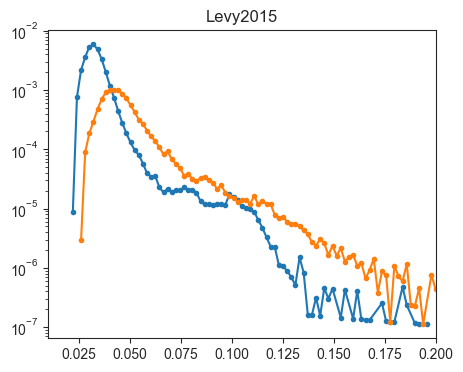

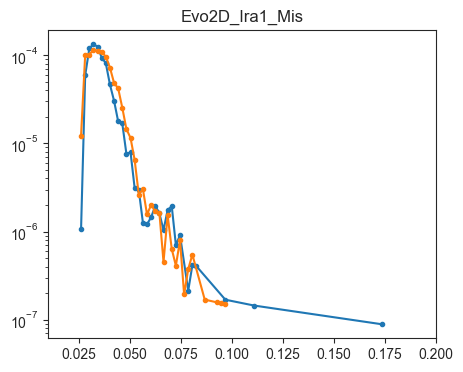

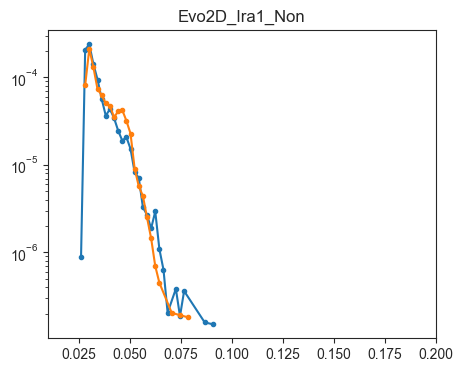

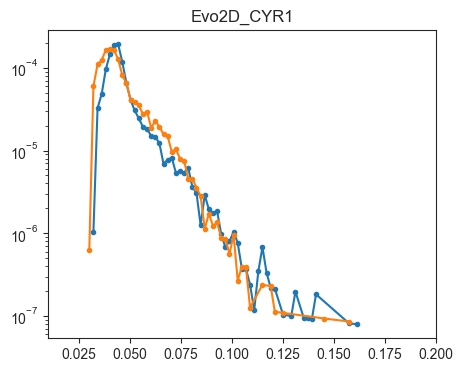

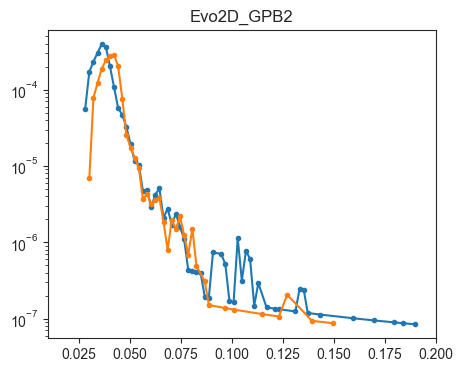

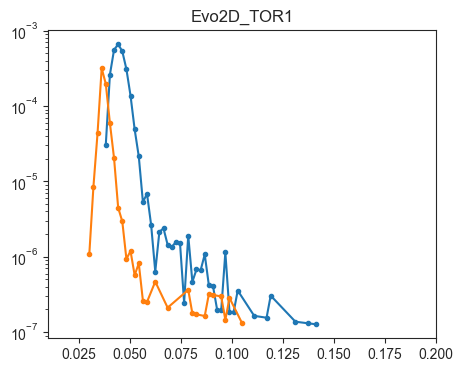

In [23]:

n0 = 1000
c = 2

def tstar(s,mean_fitness,used_timepoints,tstar_interpolation):
    
#     print(s)

    if s > max(mean_fitness):
        return used_timepoints[-1]

    else:
        return tstar_interpolation(s)
    
def time_occurence_function(t,s,unadaptive_interpolation):
    
#     print(t,s)
    return np.exp(-np.exp(-s*t))*unadaptive_interpolation(t)


s_space = np.linspace(s_min,s_max,int((s_max-s_min)/delta_s))

timeopportunity_dfe_ests = {}

for condition,reps in condition_properties.items():
    plt.figure(figsize=(5,4))
    plt.title(condition)
    
    for rep,timepoints in reps.items():
        
#         plt.subplot(1,2,rep)
        
        this_fit_mut = fitmuts_big[f'{condition}_{rep}']
        mean_fitness = mean_fitness_big[f'{condition}_{rep}']
        used_timepoints = used_timepoints_big[f'{condition}_{rep}']
        these_freqs = freqs_big[f'{condition}_{rep}']
        
        effective_lineage_size = effective_n/len(this_fit_mut)
        
        if 'Levy2015' in condition:
            used_timepoints = np.asarray(used_timepoints)
        elif condition in aggeli_conditions:
            used_timepoints = np.asarray(used_timepoints)
        else:
            used_timepoints = 8*np.asarray(used_timepoints)
        
        adaptives = this_fit_mut[this_fit_mut['Fitness']>0]

        unadaptive_ix = np.where(this_fit_mut['Fitness']==0)[0]
        
        unadaptive_fraction = np.nansum(these_freqs[unadaptive_ix,:],axis=0)
        
        print(mean_fitness)
        print(unadaptive_fraction)
        
        if used_timepoints[0] != 0: # some trouble with mean fitness interpolation if the first entry isn't T0..
            used_timepoints = np.insert(used_timepoints,0,0)
            mean_fitness = np.insert(mean_fitness,0,1e-5)
            unadaptive_fraction = np.insert(unadaptive_fraction,0,unadaptive_fraction[0])

        if program_used == 'fitmut1':
            mean_fitness_interpolation = scipy.interpolate.interp1d(used_timepoints[:-1],mean_fitness,kind=1)
#             ts = np.linspace(used_timepoints[0],used_timepoints[-2],150)
            tstar_interpolation = scipy.interpolate.interp1d(mean_fitness,used_timepoints[:-1]-np.log(effective_lineage_size*mean_fitness/c))

        else:
            mean_fitness_interpolation = scipy.interpolate.interp1d(used_timepoints,mean_fitness,kind=1)
#             ts = np.linspace(used_timepoints[0],used_timepoints[-1],150)
            tstar_interpolation = scipy.interpolate.interp1d(mean_fitness,used_timepoints-np.log(effective_lineage_size*mean_fitness/c))


        

        # returns time associated with mean fitness of s
#         mean_fitness_inverse_interpolation = scipy.interpolate.interp1d(mean_fitness,used_timepoints,kind=1)

        unadaptive_interpolation = scipy.interpolate.interp1d(used_timepoints,unadaptive_fraction,kind=1)
        
        print(unadaptive_interpolation(0))
        
        
        probs = []
        for s in s_space:

            time_to_occur = scipy.integrate.quad(time_occurence_function,
                                                 0,tstar(s,mean_fitness,used_timepoints,tstar_interpolation),
                                                args=(s,unadaptive_interpolation))

            adaptives_here = adaptives[adaptives['Fitness'].between(s,s+delta_s)]
            
            if len(adaptives_here) > 0:
                prob = len(adaptives_here)/(delta_s * (s/c) * effective_n * time_to_occur[0])
                probs.append(prob)
            else:
                probs.append(np.nan)
                
#         print(probs)

        probs = np.asarray(probs)
    
        timeopportunity_dfe_ests[f'{condition}_{rep}'] = probs
        
        probs_mask = np.isfinite(probs)
        plt.errorbar(s_space[probs_mask],probs[probs_mask],
             marker='.',
             linestyle='-')
        
        plt.yscale('log')
        plt.xlim(s_min,s_max)
        
    plt.savefig(f'{figure_directory}/mutation_rate_spectrum_TimeOpportunity_{condition}.pdf',bbox_inches='tight')

In [24]:
### convert to per-cycle fitness measurements (s_space * 8)
s_space = 8*s_space
s_min = 8*s_min
s_max = 8*s_max

KeyError: 56

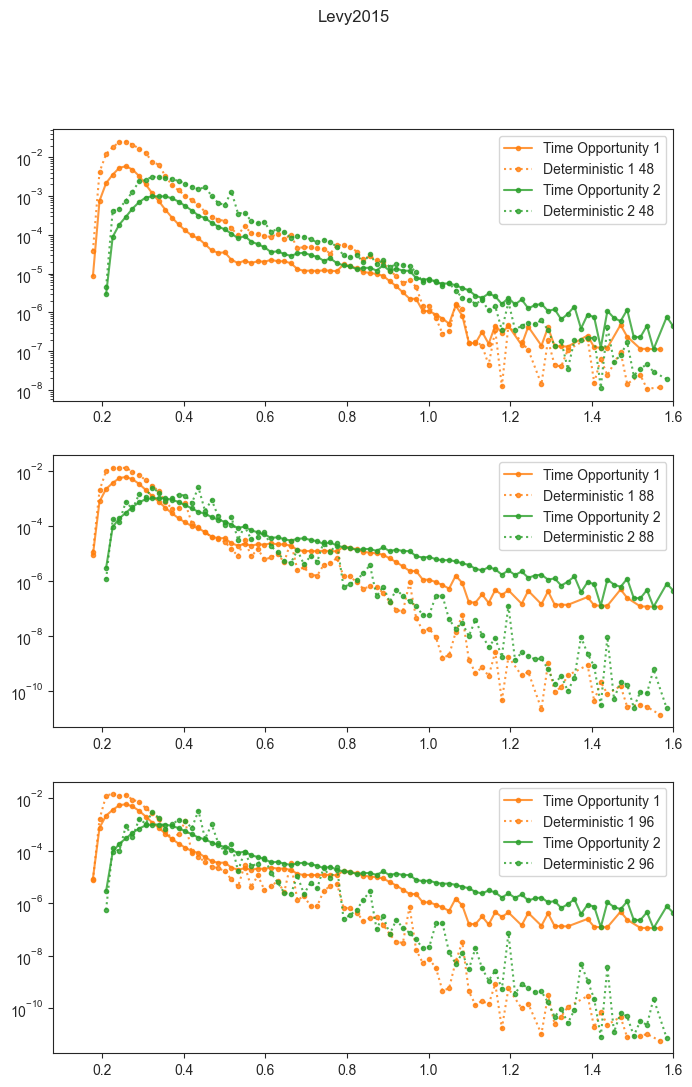

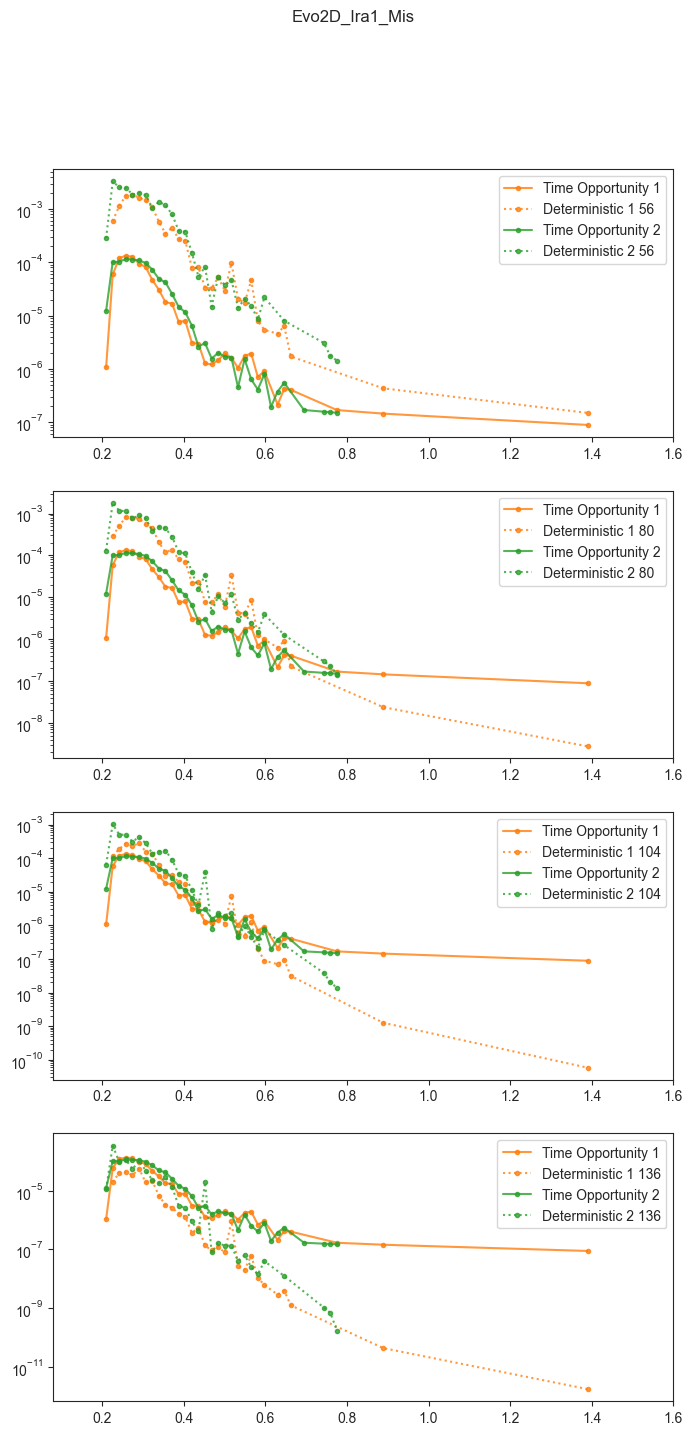

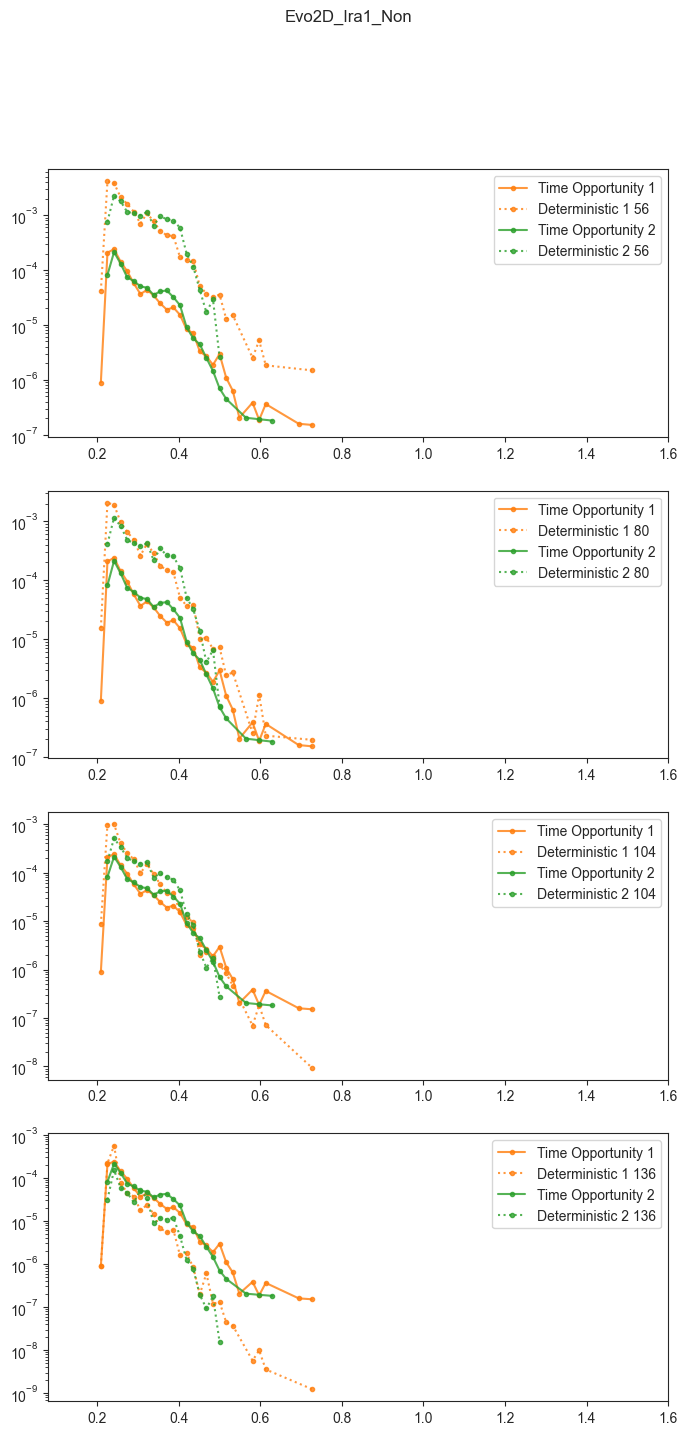

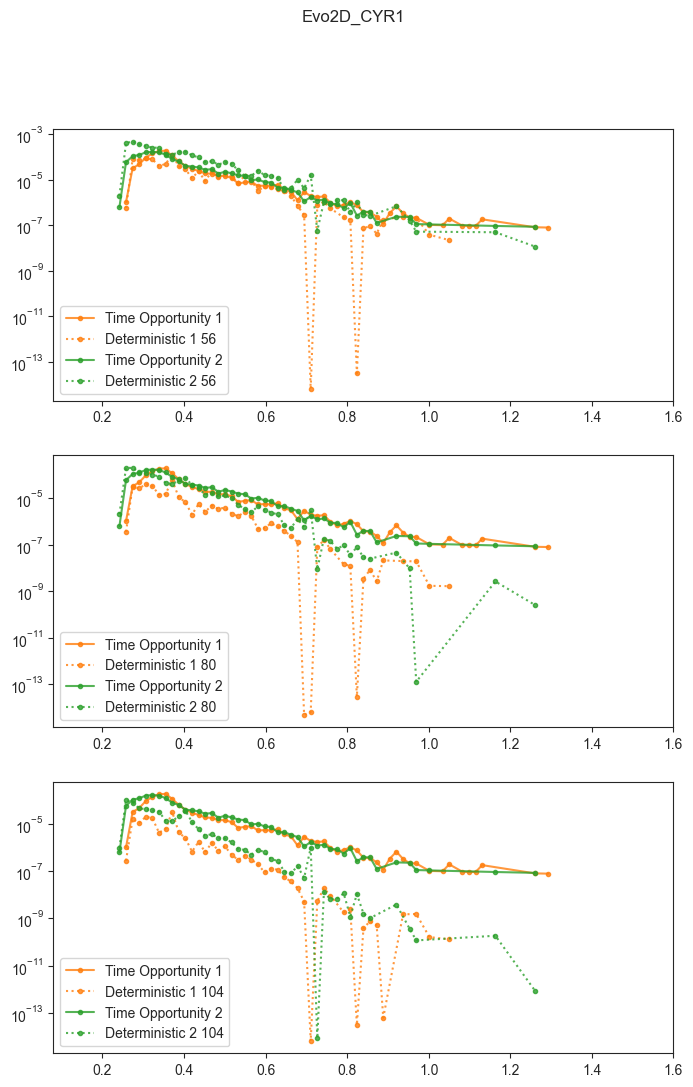

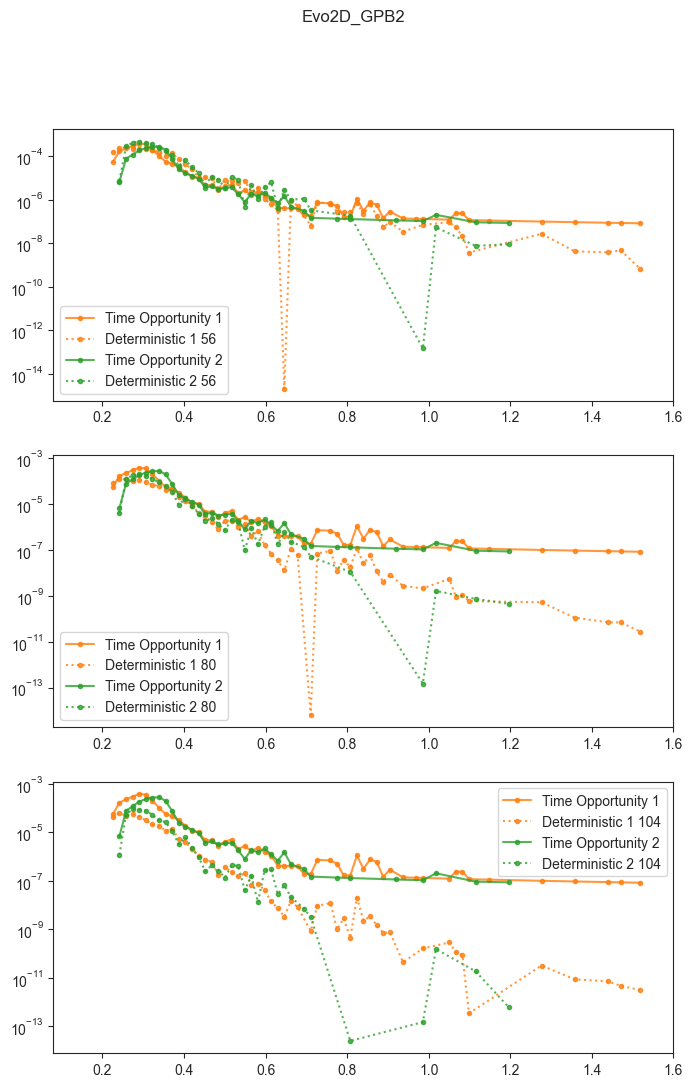

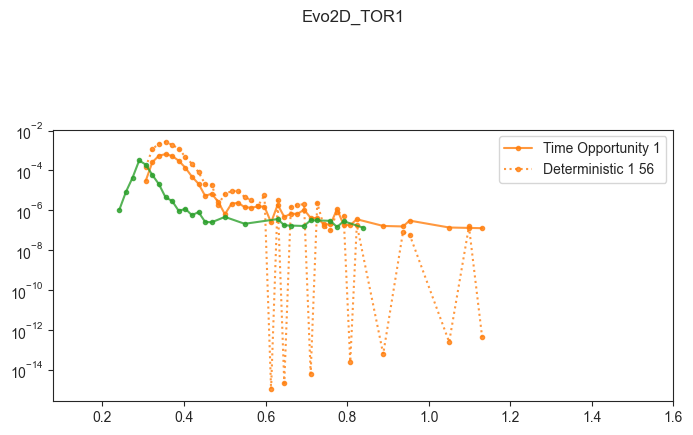

In [25]:


chosen_times_dict = {'Levy2015':[48,88,96],
                     'Evo2D_CYR1':[56,80,104],                 
                     'Evo2D_GPB2':[56,80,104],
                     'Evo2D_TOR1':[56,80,104],
#                         'Evo2D_TOR1'
                    'Evo2D_Ira1_Mis':[56,80,104,136],
                     'Evo2D_Ira1_Non':[56,80,104,136],
                     'Evo3D_Ira1_Mis':[56,80,112],
                     'Evo3D_Ira1_Non':[56,80,112]}
                     
# chosen_times = [80]

for condition,reps in condition_properties.items():
    
    chosen_times = chosen_times_dict[condition]
    
    plt.figure(figsize=(8,len(chosen_times)*4))
    plt.suptitle(condition)
    
    for c,chosen_time in enumerate(chosen_times):
        plt.subplot(len(chosen_times),1,c+1)
        for rep,timepoints in reps.items():

            probs = timeopportunity_dfe_ests[f'{condition}_{rep}']

            probs_mask = np.isfinite(probs)
            plt.errorbar(s_space[probs_mask],probs[probs_mask],
                 marker='.',
                 linestyle='-',
                color=sns.color_palette()[rep],label=f'Time Opportunity {rep}',alpha=0.8)
            
            mus = deterministic_dfe_ests[f'{condition}_{rep}'][chosen_time]
            
            probs_mask = np.isfinite(mus)
            plt.errorbar(s_space[probs_mask],mus[probs_mask],
                 marker='.',
                 linestyle=':',
                color=sns.color_palette()[rep],label=f'Deterministic {rep} {chosen_time}',alpha=0.8)
            
            plt.yscale('log')
            plt.xlim(s_min,s_max)
            plt.legend()
            
#             plt.ylim(10**-9,5*10**-4)
            
    plt.savefig(f'{figure_directory}/dfe_method_comparision_{condition}.pdf',bbox_inches='tight')


KeyError: 80

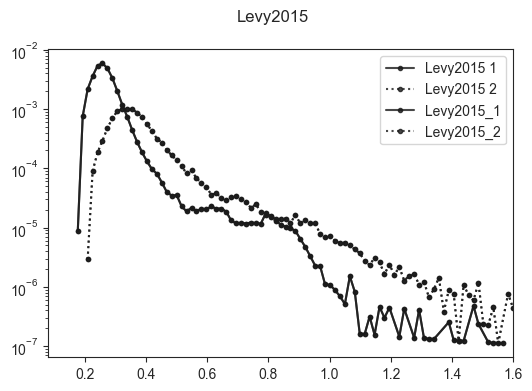

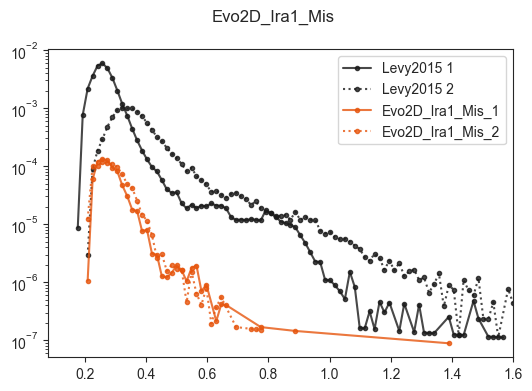

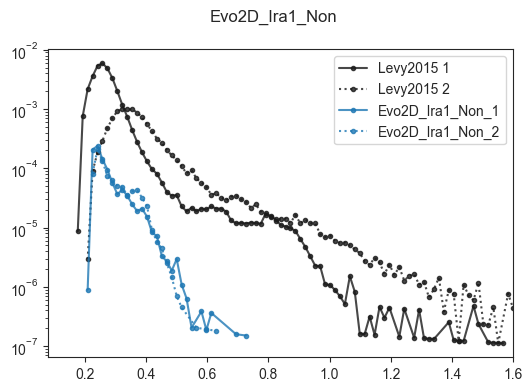

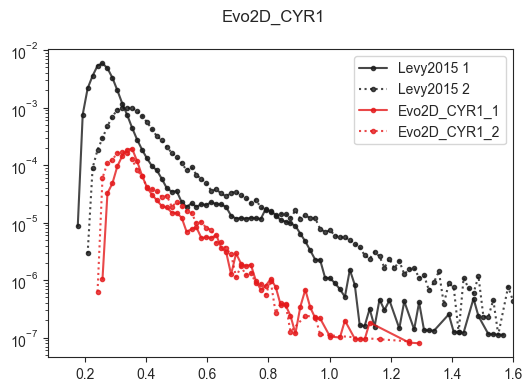

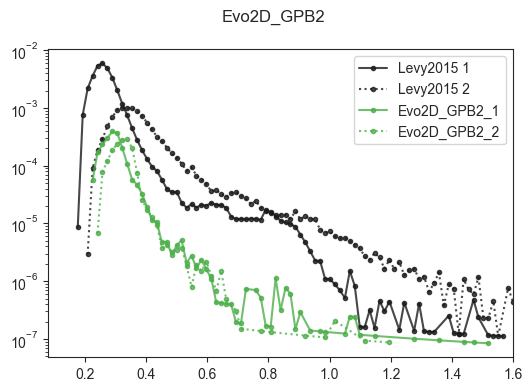

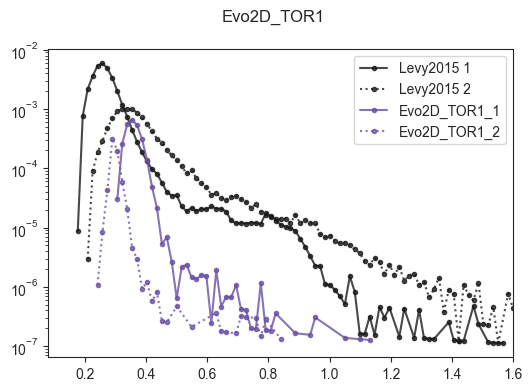

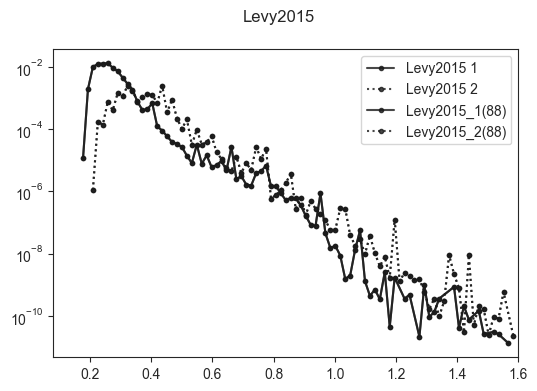

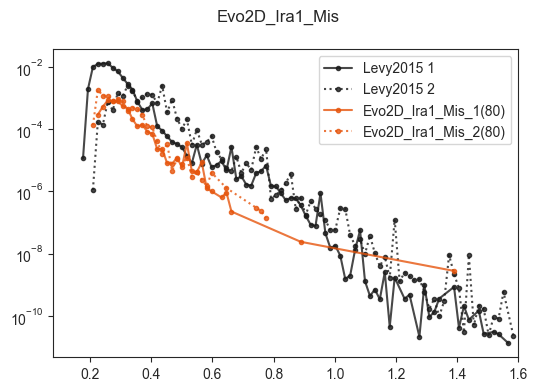

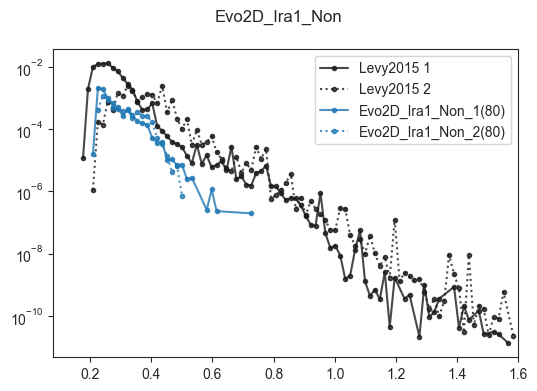

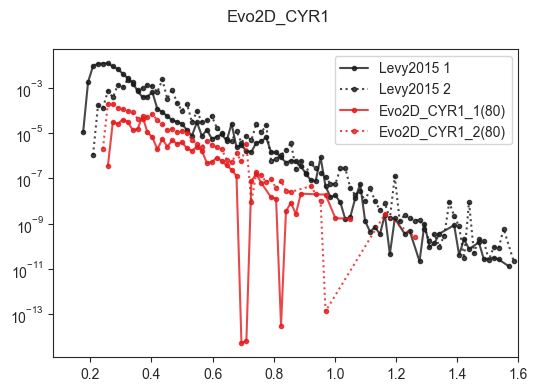

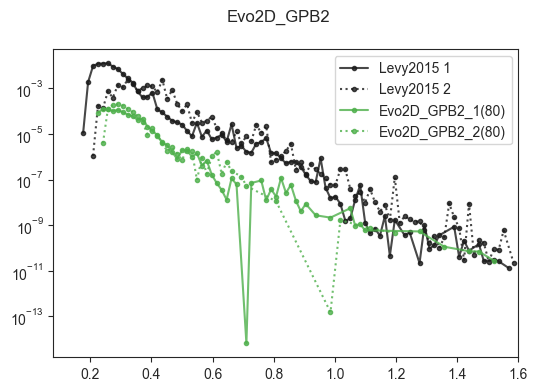

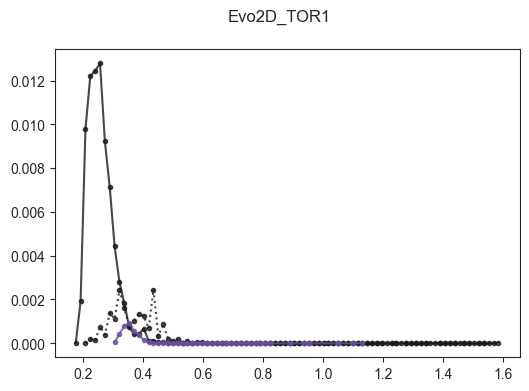

In [26]:
condition_properties = {
                        'Levy2015':{1:[0,16,32,40,48,64,72,80,88,96,104,112],
                                   2:[0,8,24,40,48,56,64,72,88,96] },
#                         'Evo1D_IRAs':{1:[0,1,4,7,10,13,16,19,22,24],
#                                       2:[0,1,4,7,10,13,16,19,22,24]},
#                         'Evo1D_TCG':{1:[0,1,4,8,10,13,16,19,22,24],
#                                     2:[0,1,4,8,10,13,16,19,22,24]},
                        
                        'Evo2D_Ira1_Mis':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
                        'Evo2D_Ira1_Non':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
    
                       
                        'Evo2D_CYR1':{1:[0, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
                                         2:[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 128, 136, 144, 152, 160]},
                        'Evo2D_GPB2':{1:[0, 8, 32, 56, 64, 80, 104, 120],
                                         2:[0, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 136, 144, 160]},
                        'Evo2D_TOR1':{1:[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
                                         2:[0, 16, 24, 40, 48, 64, 72, 88, 104, 112, 120, 128, 136, 152, 160]},                        
  
                        
#                         'Evo3D_Ira1_Mis':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21],
#                                          3:[0,1,4,7,10,14,17,21]},
#                         'Evo3D_Ira1_Non':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21],
#                                          3:[0,1,4,7,10,14,17,21]},
                        
#                         'Evo3D_TCG':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21]},               
                       }

# chosen_times_dict = {'Levy2015':[48,88,96],
#                     'Evo2D_Ira1_Mis':[56,80,104],
#                      'Evo2D_Ira1_Non':[56,80,104],
#                      'Evo3D_Ira1_Mis':[56,80,112],
#                      'Evo3D_Ira1_Non':[56,80,112]}
                     
# chosen_times = [80]

linestyle_list = ['-',':','--']

color_map = {'Levy2015':'k',
             'Evo2D_Ira1_Mis':'#e6550d',
             'Evo2D_Ira1_Non':tools.anc_color_map['IRA1_NON'],
             'Evo2D_CYR1':tools.anc_color_map['CYR1'],
             'Evo2D_GPB2':tools.anc_color_map['GPB2'],
             'Evo2D_TOR1':tools.anc_color_map['TOR1'],
            }

for condition,reps in condition_properties.items():
    
#     chosen_times = chosen_times_dict[condition]
    
    plt.figure(figsize=(6,4))
    plt.suptitle(condition)
    
    for levy_rep in [1,2]:
    
        probs = timeopportunity_dfe_ests[f'Levy2015_{levy_rep}']

        probs_mask = np.isfinite(probs)
        plt.errorbar(s_space[probs_mask],probs[probs_mask],
             marker='.',
             linestyle=linestyle_list[levy_rep-1],
            color='k',label=f'Levy2015 {levy_rep}',alpha=0.8)
    
    for rep,timepoints in reps.items():

        probs = timeopportunity_dfe_ests[f'{condition}_{rep}']

        probs_mask = np.isfinite(probs)
        plt.errorbar(s_space[probs_mask],probs[probs_mask],
             marker='.',
             linestyle=linestyle_list[rep-1],
            color=color_map[condition],label=f'{condition}_{rep}',alpha=0.8)

    plt.yscale('log')
    plt.xlim(s_min,s_max)
    plt.legend()

#     plt.ylim(10**-9,7*10**-4)
            
    plt.savefig(f'{figure_directory}/dfe_comparison_timeopportunity_{condition}_vs_Levy2015.pdf',bbox_inches='tight')

    


# chosen_times_dict = {'Levy2015':[48,88,96],
#                     'Evo2D_Ira1_Mis':[56,80,104],
#                      'Evo2D_Ira1_Non':[56,80,104],
#                      'Evo3D_Ira1_Mis':[56,80,112],
#                      'Evo3D_Ira1_Non':[56,80,112]}
                     

chosen_times = {'Levy2015':88,
                'Evo2D_CYR1':80,
                'Evo2D_GPB2':80,
                'Evo2D_TOR1':80,
                'Evo2D_Ira1_Mis':80,
                'Evo2D_Ira1_Non':80,
                'Evo3D_Ira1_Mis':80,
                'Evo3D_Ira1_Non':80}

linestyle_list = ['-',':','--']

for condition,reps in condition_properties.items():
    
#     chosen_times = chosen_times_dict[condition]
    
    plt.figure(figsize=(6,4))
    plt.suptitle(condition)
    
    for levy_rep in [1,2]:
    
        probs = deterministic_dfe_ests[f'Levy2015_{levy_rep}'][chosen_times['Levy2015']]

        probs_mask = np.isfinite(probs)
        plt.errorbar(s_space[probs_mask],probs[probs_mask],
             marker='.',
             linestyle=linestyle_list[levy_rep-1],
            color='k',label=f'Levy2015 {levy_rep} ',alpha=0.8)
    
    for rep,timepoints in reps.items():
        
#         chosen_time

        probs = deterministic_dfe_ests[f'{condition}_{rep}'][chosen_times[condition]]

        probs_mask = np.isfinite(probs)
        plt.errorbar(s_space[probs_mask],probs[probs_mask],
             marker='.',
             linestyle=linestyle_list[rep-1],
            color=color_map[condition],label=f'{condition}_{rep}({chosen_times[condition]})',alpha=0.8)

    plt.yscale('log')
    plt.xlim(s_min,s_max)
    plt.legend()

#     plt.ylim(10**-9,7*10**-4)
            
    plt.savefig(f'{figure_directory}/dfe_comparison_deterministic_{condition}_vs_Levy2015.pdf',bbox_inches='tight')





In [ ]:
timeopportunity_dfe_ests

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3188097177.py:92: RuntimeWarning: Mean of empty slice
  probs_avg = np.nanmean(prob_array,axis=1)
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_77357/3188097177.py:166: RuntimeWarning: Mean of empty slice
  probs_avg = np.nanmean(prob_array,axis=1)


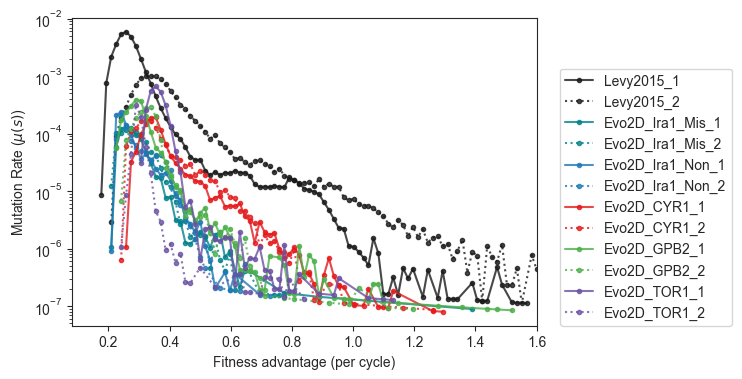

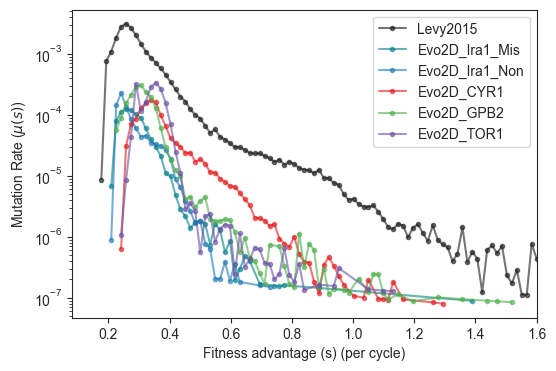

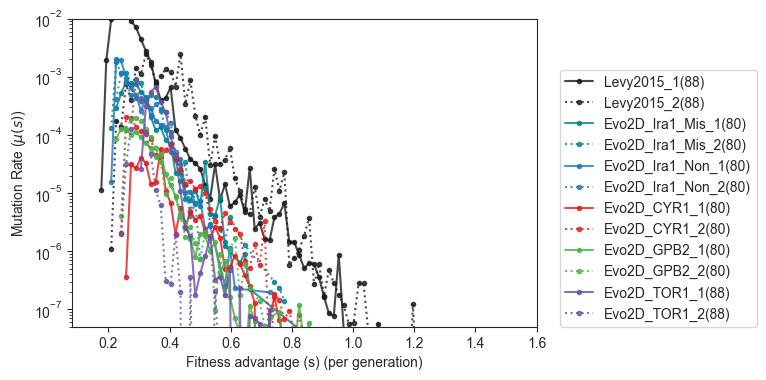

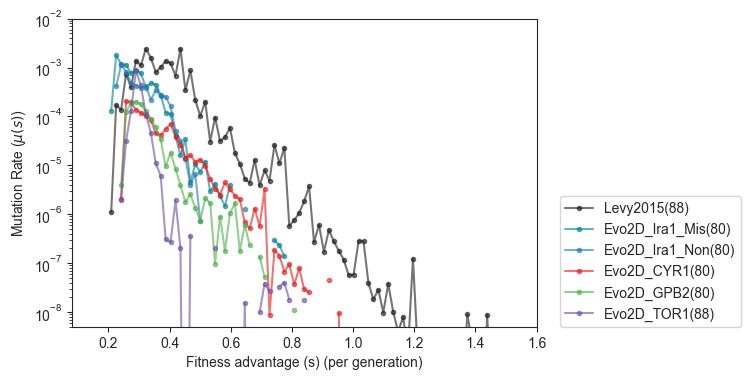

In [28]:
condition_properties = {
                        'Levy2015':{1:[0,16,32,40,48,64,72,80,88,96,104,112],
                                   2:[0,8,24,40,48,56,64,72,88,96] },
#                         'Evo1D_IRAs':{1:[0,1,4,7,10,13,16,19,22,24],
#                                       2:[0,1,4,7,10,13,16,19,22,24]},
#                         'Evo1D_TCG':{1:[0,1,4,8,10,13,16,19,22,24],
#                                     2:[0,1,4,8,10,13,16,19,22,24]},
                        
                        'Evo2D_Ira1_Mis':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
                        'Evo2D_Ira1_Non':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
    
                       
                        'Evo2D_CYR1':{1:[0, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
                                         2:[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 128, 136, 144, 152, 160]},
                        'Evo2D_GPB2':{1:[0, 8, 32, 56, 64, 80, 104, 120],
                                         2:[0, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 136, 144, 160]},
                        'Evo2D_TOR1':{1:[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
                                         2:[0, 16, 24, 40, 48, 64, 72, 88, 104, 112, 120, 128, 136, 152, 160]},                        
  
                        
#                         'Evo3D_Ira1_Mis':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21],
#                                          3:[0,1,4,7,10,14,17,21]},
#                         'Evo3D_Ira1_Non':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21],
#                                          3:[0,1,4,7,10,14,17,21]},
                        
#                         'Evo3D_TCG':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21]},               
                       }

# chosen_times_dict = {'Levy2015':[48,88,96],
#                     'Evo2D_Ira1_Mis':[56,80,104],
#                      'Evo2D_Ira1_Non':[56,80,104],
#                      'Evo3D_Ira1_Mis':[56,80,112],
#                      'Evo3D_Ira1_Non':[56,80,112]}
                     
# chosen_times = [80]

linestyle_list = ['-',':','--']

color_map = {'Levy2015':'k',
#              'Evo2D_Ira1_Mis':'#e6550d',
             'Evo2D_Ira1_Mis':tools.anc_color_map['IRA1_MIS'],
             'Evo2D_Ira1_Non':tools.anc_color_map['IRA1_NON'],
             'Evo2D_CYR1':tools.anc_color_map['CYR1'],
             'Evo2D_GPB2':tools.anc_color_map['GPB2'],
             'Evo2D_TOR1':tools.anc_color_map['TOR1'],
            }

plt.figure(figsize=(6,4))
# plt.suptitle(condition)

for condition,reps in condition_properties.items():
    
    for rep,timepoints in reps.items():

        probs = timeopportunity_dfe_ests[f'{condition}_{rep}']

        probs_mask = np.isfinite(probs)
        plt.errorbar(s_space[probs_mask],probs[probs_mask],
             marker='.',
             linestyle=linestyle_list[rep-1],
            color=color_map[condition],label=f'{condition}_{rep}',alpha=0.8)

plt.yscale('log')
plt.xlim(s_min,s_max)
plt.legend(loc=(1.05,0))

plt.xlabel('Fitness advantage (per cycle)')
plt.ylabel('Mutation Rate ($\mu(s)$)')

# plt.ylim(10**-9,7*10**-4)
            
plt.savefig(f'{figure_directory}/dfe_comparison_timeopportunity_allEvo2D.pdf',bbox_inches='tight')


plt.figure(figsize=(6,4))
# plt.suptitle(condition)

for condition,reps in condition_properties.items():
    
    prob_array = np.empty((len(s_space),len(reps.keys())))
    
    for rep,timepoints in reps.items():
        
        probs = timeopportunity_dfe_ests[f'{condition}_{rep}']
        prob_array[:,rep-1] = probs
        
    probs_avg = np.nanmean(prob_array,axis=1)
    probs_mask = np.isfinite(probs_avg)
        
    plt.errorbar(s_space[probs_mask],probs_avg[probs_mask],
             marker='.',linestyle='-',
#              linestyle=linestyle_list[rep-1],
            color=color_map[condition],label=f'{condition}',alpha=0.6)

plt.yscale('log')
plt.xlim(s_min,s_max)
plt.legend(loc='upper right')

plt.xlabel('Fitness advantage (s) (per cycle)')
plt.ylabel('Mutation Rate ($\mu(s)$)')

# plt.ylim(10**-9,7*10**-4)
            
plt.savefig(f'{figure_directory}/dfe_comparison_timeopportunity_AVG_allEvo2D.pdf',bbox_inches='tight')




chosen_times = {'Levy2015':88,
                'Evo2D_CYR1':80,
                'Evo2D_GPB2':80,
                'Evo2D_TOR1':88,
                'Evo2D_Ira1_Mis':80,
                'Evo2D_Ira1_Non':80,
                'Evo3D_Ira1_Mis':80,
                'Evo3D_Ira1_Non':80}

# label_names = {'Evo2D WT (Levy2015)':88,
#                 'Evo2D_CYR1':80,
#                 'Evo2D_GPB2':80,
#                 'Evo2D_TOR1':88,
#                 'Evo2D_Ira1_Mis':80,
#                 'Evo2D_Ira1_Non':80,
#                 'Evo3D_Ira1_Mis':80,
#                 'Evo3D_Ira1_Non':80}

plt.figure(figsize=(6,4))


for condition,reps in condition_properties.items():
    
    for rep,timepoints in reps.items():
        
#         chosen_time =

        probs = deterministic_dfe_ests[f'{condition}_{rep}'][chosen_times[condition]]
    
        

        probs_mask = np.isfinite(probs)
        plt.errorbar(s_space[probs_mask],probs[probs_mask],
             marker='.',
             linestyle=linestyle_list[rep-1],
            color=color_map[condition],label=f'{condition}_{rep}({chosen_times[condition]})',alpha=0.8)

plt.yscale('log')
plt.ylim(5*10**-8,10**-2)
plt.xlim(s_min,s_max)
plt.legend(loc=(1.05,0))

plt.xlabel('Fitness advantage (s) (per generation)')
plt.ylabel('Mutation Rate ($\mu(s)$)')

# plt.ylim(10**-9,7*10**-4)

plt.savefig(f'{figure_directory}/dfe_comparison_deterministic_AllEvo2D.pdf',bbox_inches='tight')

plt.figure(figsize=(6,4))


for condition,reps in condition_properties.items():
    
    prob_array = np.empty((len(s_space),len(reps.keys())))
    
    for rep,timepoints in reps.items():
        
        probs = deterministic_dfe_ests[f'{condition}_{rep}'][chosen_times[condition]]
        prob_array[:,rep-1] = probs

    probs_avg = np.nanmean(prob_array,axis=1)
    probs_mask = np.isfinite(probs_avg)

#         probs_mask = np.isfinite(probs)
    plt.errorbar(s_space[probs_mask],probs[probs_mask],
         marker='.',
         linestyle='-',
        color=color_map[condition],label=f'{condition}({chosen_times[condition]})',alpha=0.6)

plt.yscale('log')
plt.ylim(5*10**-9,10**-2)
plt.xlim(s_min,s_max)
plt.legend(loc=(1.05,0))

plt.xlabel('Fitness advantage (s) (per generation)')
plt.ylabel('Mutation Rate ($\mu(s)$)')

# plt.ylim(10**-9,7*10**-4)

plt.savefig(f'{figure_directory}/dfe_comparison_deterministic_AllEvo2D_avg.pdf',bbox_inches='tight')

AttributeError: 'Line2D' object has no property 'tcolor'

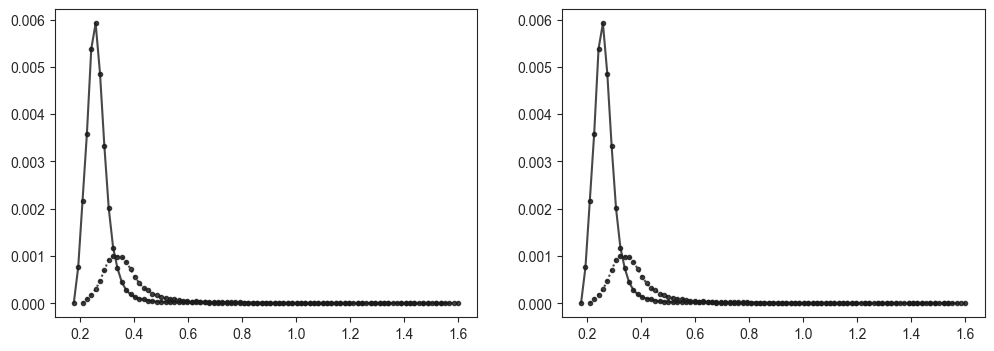

In [27]:
condition_properties = {
                        'Levy2015':{1:[0,16,32,40,48,64,72,80,88,96,104,112],
                                   2:[0,8,24,40,48,56,64,72,88,96] },
#                         'Evo1D_IRAs':{1:[0,1,4,7,10,13,16,19,22,24],
#                                       2:[0,1,4,7,10,13,16,19,22,24]},
#                         'Evo1D_TCG':{1:[0,1,4,8,10,13,16,19,22,24],
#                                     2:[0,1,4,8,10,13,16,19,22,24]},
                        
                        'Evo2D_Ira1_Mis':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
                        'Evo2D_Ira1_Non':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
    
                       
#                         'Evo2D_CYR1':{1:[0, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
#                                          2:[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 128, 136, 144, 152, 160]},
#                         'Evo2D_GPB2':{1:[0, 8, 32, 56, 64, 80, 104, 120],
#                                          2:[0, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 136, 144, 160]},
#                         'Evo2D_TOR1':{1:[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
#                                          2:[0, 16, 24, 40, 48, 64, 72, 88, 104, 112, 120, 128, 136, 152, 160]},                        
  
                        
                        'Evo3D_Ira1_Mis':{1:[0,1,4,7,10,14,17,21],
                                         2:[0,1,4,7,10,14,17,21],
                                         3:[0,1,4,7,10,14,17,21]},
                        'Evo3D_Ira1_Non':{1:[0,1,4,7,10,14,17,21],
                                         2:[0,1,4,7,10,14,17,21],
                                         3:[0,1,4,7,10,14,17,21]},
                        
#                         'Evo3D_TCG':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21]},               
                       }

# chosen_times_dict = {'Levy2015':[48,88,96],
#                     'Evo2D_Ira1_Mis':[56,80,104],
#                      'Evo2D_Ira1_Non':[56,80,104],
#                      'Evo3D_Ira1_Mis':[56,80,112],
#                      'Evo3D_Ira1_Non':[56,80,112]}
                     
# chosen_times = [80]

linestyle_list = ['-',':','--']

color_map = {'Levy2015':'k',
#              'Evo2D_Ira1_Mis':'#e6550d',
             'Evo2D_Ira1_Mis':tools.anc_evo_cond_color_map['IRA1_MIS']['Evo2D'],
             'Evo2D_Ira1_Non':tools.anc_evo_cond_color_map['IRA1_NON']['Evo2D'],
             
             'Evo3D_Ira1_Mis':tools.anc_evo_cond_color_map['IRA1_MIS']['Evo3D'],
             'Evo3D_Ira1_Non':tools.anc_evo_cond_color_map['IRA1_NON']['Evo3D'],
             'Evo2D_CYR1':tools.anc_color_map['CYR1'],
             'Evo2D_GPB2':tools.anc_color_map['GPB2'],
             'Evo2D_TOR1':tools.anc_color_map['TOR1'],
            }

fig,axs = plt.subplots(figsize=(6*2,4),ncols=2)
# plt.suptitle(condition)

for condition,reps in condition_properties.items():
    
    for rep,timepoints in reps.items():
        probs = timeopportunity_dfe_ests[f'{condition}_{rep}']

        probs_mask = np.isfinite(probs)
        
        if 'Levy2015' in condition:
            axs[0].errorbar(s_space[probs_mask],probs[probs_mask],
                 marker='.',
                 linestyle=linestyle_list[rep-1],
                color=color_map[condition],label=f'{condition}_{rep}',alpha=0.8)
            axs[1].errorbar(s_space[probs_mask],probs[probs_mask],
                 marker='.',
                 linestyle=linestyle_list[rep-1],
                color=color_map[condition],label=f'{condition}_{rep}',alpha=0.8)
         
        if 'Ira1_Mis' in condition:
            axs[0].errorbar(s_space[probs_mask],probs[probs_mask],
                 marker='.',
                 linestyle=linestyle_list[rep-1],
                tcolor=color_map[condition],label=f'{condition}_{rep}',alpha=0.8)
            
        elif 'Ira1_Non' in condition:
            axs[1].errorbar(s_space[probs_mask],probs[probs_mask],
                 marker='.',
                 linestyle=linestyle_list[rep-1],
                color=color_map[condition],label=f'{condition}_{rep}',alpha=0.8)

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlim(s_min,s_max)
#     ax.egend(loc=(1.05,0))

    ax.set_xlabel('Fitness advantage (per generation)')
    ax.set_ylabel('Density $\mu(s)$')

# plt.ylim(10**-9,7*10**-4)
            
plt.savefig(f'{figure_directory}/dfe_comparison_timeopportunity_IRAs.pdf',bbox_inches='tight')


In [ ]:

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.figure(figsize=(6,4))
# plt.suptitle(condition)

for condition,reps in condition_properties.items():
    
    prob_array = np.empty((len(s_space),len(reps.keys())))
    
    for rep,timepoints in reps.items():
        
        probs = timeopportunity_dfe_ests[f'{condition}_{rep}']
        prob_array[:,rep-1] = probs
        
    probs_avg = np.nanmean(prob_array,axis=1)
    probs_mask = np.isfinite(probs_avg)
        
    plt.errorbar(s_space[probs_mask],probs_avg[probs_mask],
             marker='.',linestyle='-',
#              linestyle=linestyle_list[rep-1],
            color=color_map[condition],label=f'{condition}_{rep}',alpha=0.8)

plt.yscale('log')
plt.xlim(s_min,s_max)
plt.legend(loc=(1.05,0))

plt.xlabel('Fitness advantage (s) (per generation)')
plt.ylabel('Density $\mu(s)$')

# plt.ylim(10**-9,7*10**-4)
            
plt.savefig(f'{figure_directory}/dfe_comparison_timeopportunity_AVG_allEvo2D.pdf',bbox_inches='tight')



In [ ]:
condition_properties = {
#                         'Levy2015':{1:[0,16,32,40,48,64,72,80,88,96,104,112],
#                                    2:[0,8,24,40,48,56,64,72,88,96] },
#                         'Evo1D_IRAs':{1:[0,1,4,7,10,13,16,19,22,24],
#                                       2:[0,1,4,7,10,13,16,19,22,24]},
#                         'Evo1D_TCG':{1:[0,1,4,8,10,13,16,19,22,24],
#                                     2:[0,1,4,8,10,13,16,19,22,24]},
                        
                        'Evo2D_Ira1_Mis':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
                        'Evo2D_Ira1_Non':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
                        
                        'Evo3D_Ira1_Mis':{1:[0,1,4,7,10,14,17,21],
                                         2:[0,1,4,7,10,14,17,21],
                                         3:[0,1,4,7,10,14,17,21]},
                        'Evo3D_Ira1_Non':{1:[0,1,4,7,10,14,17,21],
                                         2:[0,1,4,7,10,14,17,21],
                                         3:[0,1,4,7,10,14,17,21]},
                        
#                         'Evo3D_TCG':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21]},               
                       }

merged_fitness = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)

condition_info = {'Evo2D_Ira1_Mis':{'evolution_condition':'Evo2D','ancestor':'IRA1_MIS','fit_measurement':'Fit2D_both2%5%_fitness'},
                 'Evo2D_Ira1_Non':{'evolution_condition':'Evo2D','ancestor':'IRA1_NON','fit_measurement':'Fit2D_both2%5%_fitness'},
                 'Evo3D_Ira1_Mis':{'evolution_condition':'Evo3D','ancestor':'IRA1_MIS','fit_measurement':'Fit3D_both2%5%_fitness'},
                 'Evo3D_Ira1_Non':{'evolution_condition':'Evo3D','ancestor':'IRA1_NON','fit_measurement':'Fit3D_both2%5%_fitness'}}

condition_info = {'Evo2D_Ira1_Mis':{'evolution_condition':'Evo2D','ancestor':'IRA1_MIS','fit_measurement':'Fit2D_both2%5%_fitness'},
                 'Evo2D_Ira1_Non':{'evolution_condition':'Evo2D','ancestor':'IRA1_NON','fit_measurement':'Fit2D_both2%5%_fitness'},
                 'Evo3D_Ira1_Mis':{'evolution_condition':'Evo3D','ancestor':'IRA1_MIS','fit_measurement':'Fit5D_both2%5%_fitness'},
                 'Evo3D_Ira1_Non':{'evolution_condition':'Evo3D','ancestor':'IRA1_NON','fit_measurement':'Fit5D_both2%5%_fitness'}}



# condition_info = {'Evo2D_Ira1_Mis':{'evolution_condition':'Evo2D','ancestor':'IRA1_MIS','fit_measurement':'Fit2D_early_fitness'},
#                  'Evo2D_Ira1_Non':{'evolution_condition':'Evo2D','ancestor':'IRA1_NON','fit_measurement':'Fit2D_early_fitness'}}

linestyle_list = ['-',':','--']


color_map = {'Levy2015':'k',
             'Evo2D_Ira1_Mis':'#e6550d',
             'Evo2D_Ira1_Non':tools.anc_color_map['IRA1_NON'],
             'Evo2D_CYR1':tools.anc_color_map['CYR1'],
             'Evo2D_GPB2':tools.anc_color_map['GPB2'],
             'Evo2D_TOR1':tools.anc_color_map['TOR1'],
                'Evo3D_Ira1_Mis':'#e6550d',
             'Evo3D_Ira1_Non':tools.anc_color_map['IRA1_NON'],
            }



# plt.suptitle(condition)

for condition,reps in condition_properties.items():
    plt.figure(figsize=(6,4))

    for rep,timepoints in reps.items():

        probs = timeopportunity_dfe_ests[f'{condition}_{rep}']

        probs_mask = np.isfinite(probs)
        plt.errorbar(8*s_space[probs_mask],probs[probs_mask]/np.nansum(probs),
             marker='.',
             linestyle=linestyle_list[rep-1],
            color=color_map[condition],label=f'{condition}_{rep}',alpha=0.8)
        
    
    
    sampled = merged_fitness[(merged_fitness['evolution_condition']==condition_info[condition]['evolution_condition']) & 
                            (merged_fitness['ancestor']==condition_info[condition]['ancestor'])]
    
    
    
    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[condition_info[condition]['ancestor']]]
    
    fitnesses = sampled[condition_info[condition]['fit_measurement']].values-background_mutant[condition_info[condition]['fit_measurement']].values[0]
    
    double_muts = []
#     for fitness,gene in zip(fitnesses,sampled['gene'].values):
#         if not p.isnull(gene):
#             if '+' in gene:
#                 double_muts.append(True)
#             else:
#                 double_muts.append(False)
#         else:
#             double_muts.append(False)

    for fitness,gene in zip(fitnesses,sampled['gene'].values):
        if not p.isnull(gene):
            if '+' in gene:
                double_muts.append('double')
            else:
                double_muts.append('single')
        else:
            double_muts.append('not sequenced')
        
    
    long_formed_data = p.DataFrame({'fitness':fitnesses,
                                'gene':sampled['gene'].values,
                                'sequenced':~p.isnull(sampled['gene'].values),
                                'double_mutant':double_muts,
                               })
    
    
    
#     sns.histplot(fitnesses,color=color_map[condition],stat='probability',alpha=0.5)
    sns.histplot(long_formed_data,x='fitness',hue='double_mutant',
                 stat='probability',multiple='stack',alpha=1,legend=True,
                 hue_order=['single','not sequenced','double'],
                 palette={'single':color_map[condition],'not sequenced':'gray','double':'k'})

    
    
#     plt.yscale('log')
#     plt.xlim(s_min,s_max)
#     plt.legend()

    plt.xlabel('Fitness advantage (per cycle)')
    plt.ylabel('Density $\mu(s)$')

# plt.ylim(10**-9,7*10**-4)
            
    plt.savefig(f'{figure_directory}/dfe_with_sampled_timeopportunity_{condition}.pdf',bbox_inches='tight')


chosen_times = {'Levy2015':88,
                    'Evo2D_Ira1_Mis':80,
                     'Evo2D_Ira1_Non':80,
                     'Evo3D_Ira1_Mis':80,
                     'Evo3D_Ira1_Non':80}




for condition,reps in condition_properties.items():
    plt.figure(figsize=(6,4))
    for rep,timepoints in reps.items():
        
#         chosen_time =

        probs = deterministic_dfe_ests[f'{condition}_{rep}'][chosen_times[condition]]

        probs_mask = np.isfinite(probs)
        plt.errorbar(8*s_space[probs_mask],probs[probs_mask]/np.nansum(probs),
             marker='.',
             linestyle=linestyle_list[rep-1],
            color=color_map[condition],label=f'{condition}_{rep}({chosen_times[condition]})',alpha=0.8)
        
    sampled = merged_fitness[(merged_fitness['evolution_condition']==condition_info[condition]['evolution_condition']) & 
                            (merged_fitness['ancestor']==condition_info[condition]['ancestor'])]
    
    
    
#     sequenced = sampled[~p.isnull(sampled['gene'])]
    
    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[condition_info[condition]['ancestor']]]
    
    fitnesses = sampled[condition_info[condition]['fit_measurement']].values-background_mutant[condition_info[condition]['fit_measurement']].values[0]
      
#     fit_list = []
#     sequenced_list = []
    double_muts = []
    for fitness,gene in zip(fitnesses,sampled['gene'].values):
        if not p.isnull(gene):
            if '+' in gene:
                double_muts.append(True)
            else:
                double_muts.append(False)
        else:
            double_muts.append(False)
        
    
    long_formed_data = p.DataFrame({'fitness':fitnesses,
                                'gene':sampled['gene'].values,
                                'sequenced':~p.isnull(sampled['gene'].values),
                                'double_mutant':double_muts,
                               })
    
#     sequenced = p.isnull(sampled['gene'])
    
#     sns.histplot(fitnesses/8,color=color_map[condition],stat='probability',multiple='stack',hue=sequenced,alpha=0.5)
#     sns.histplot(fitnesses/8,color=color_map[condition],stat='probability',multiple='stack',hue=sequenced,alpha=0.5)
    sns.histplot(long_formed_data,x='fitness',hue='double_mutant',stat='probability',multiple='stack',alpha=1,palette=[color_map[condition],'k'])



#     sns.histplot(fitnesses_sequenced/8,color='gold',stat='probability',alpha=0.5)

    plt.legend()

    plt.xlabel('Fitness advantage (per cycle)')
    plt.ylabel('Density $\mu(s)$')

# plt.ylim(10**-9,7*10**-4)
    plt.savefig(f'{figure_directory}/dfe_with_sampled_deterministic_{condition}.pdf',bbox_inches='tight')

# plt.savefig(f'{figure_directory}/dfe_comparison_deterministic_AllEvo2D.pdf',bbox_inches='tight')

In [ ]:
background_mutant[condition_info[condition]['fit_measurement']].values[0]

In [ ]:
sampled[condition_info[condition]['fit_measurement']].values

In [ ]:
sampled = merged_fitness[(merged_fitness['evolution_condition']==condition_info[condition][0]) & 
                            (merged_fitness['ancestor']==condition_info[condition][1])]
    
    sns.histplot(sampled['Fit2D_both2%5%_fitness']/8,color=color_map[condition])